##DATA PROCESSING

###Installing and Importing neccessary libraries and data

In [ ]:
!pip install xgboost catboost lightgbm torch tabpfn --quiet
!pip install pytorch-tabnet scikit-learn pandas numpy matplotlib seaborn --quiet
!pip install lime -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.9/551.9 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
import nbformat

file = "/content/EXTERNAL_VALIDATION_of_PTB_RISK_PREDICTING_AI_MODEL.ipynb"

nb = nbformat.read(file, as_version=4)

for cell in nb["cells"]:
    if "widgets" in cell.get("metadata", {}):
        del cell["metadata"]["widgets"]

nbformat.write(nb, file)
print("Fixed and saved:", file)


Fixed and saved: /content/EXTERNAL_VALIDATION_of_PTB_RISK_PREDICTING_AI_MODEL.ipynb


Importing libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_selection import f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from google.colab import files
import re
import torch
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score, roc_curve,auc, confusion_matrix, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from tabpfn import TabPFNClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.colors as mcolors
from sklearn.feature_selection import f_classif
import statsmodels.api as sm
from collections import Counter
from imblearn.combine import SMOTEENN
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)


JUMC_SHGGH is test code from JImma Health center and JHC is training data from Jimma University Medical College and Shenen Gibe General Hospital

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 3: Read the CSV file from Google Drive
file_path = '/content/drive/MyDrive/PTB data JHC.csv'
JUMC_SHGGH_data = pd.read_csv(file_path)
file_path = '/content/drive/MyDrive/PTB data JUMC and SHGGH.csv'
JHC_data = pd.read_csv(file_path)


Mounted at /content/drive


###Feature Selection

In [ ]:
print(JUMC_SHGGH_data.columns)
JUMC_SHGGH_data.drop(['Education level', 'Smoking','Physical stress', 'Alcohol'], axis=1, inplace=True)
JUMC_SHGGH_data.head()
print(JHC_data.columns)
JHC_data.drop(['Education level', 'Smoking','Physical stress', 'Alcohol'], axis=1, inplace=True)
JHC_data.head()

Index(['Patient_ID', 'Age', 'Baby position', 'PROM', 'Education level',
       'Residence', 'Twin', 'Gest Hypertension', 'Chronic diseases',
       'Infections', 'APH', 'Uterine problem', 'Smoking', 'Alcohol',
       'Physical stress', 'Anemia', 'FHR Abnormality', 'PTB history',
       'Still birth history', 'Abortion history', 'Gravida',
       'Preclampsia/Eclampsia', 'ANC followup', 'Prev C section', 'Outcome'],
      dtype='object')
Index(['Patient_ID', 'Age', 'Baby position', 'PROM', 'Education level',
       'Residence', 'Twin', 'Gest Hypertension', 'Chronic diseases',
       'Infections', 'APH', 'Uterine problem', 'Smoking', 'Alcohol',
       'Physical stress', 'Anemia', 'FHR Abnormality', 'PTB history',
       'Still birth history', 'Abortion history', 'Gravida',
       'Preclampsia/Eclampsia', 'ANC followup', 'Prev C section', 'Outcome'],
      dtype='object')


Patient_ID  Age Baby position PROM Residence Twin Gest Hypertension  \
0    A228592   40         right   no     rural   no               yes   
1    A226594   24         right  NaN     rural   no               yes   
2    A042904   26         right  yes     urban   no               yes   
3    A225423   24           NaN  NaN     urban  NaN               yes   
4    A971233   23           NaN   no     urban   no               yes   

  Chronic diseases Infections  APH  ... Anemia FHR Abnormality PTB history  \
0               no         no   no  ...    yes              no          no   
1              NaN         no   no  ...     no             NaN          no   
2               no        yes  yes  ...     no              no          no   
3              NaN        NaN  yes  ...    yes             NaN         yes   
4               no        NaN  yes  ...     no              no          no   

  Still birth history Abortion history Gravida  Preclampsia/Eclampsia  \
0                 yes               no     3.0                    yes   
1                 yes              yes     5.0                    yes   
2                 yes               no     2.0                    yes   
3                  no              yes     5.0                     no   
4                  no               no     1.0                     no   

  ANC followup  Prev C section Outcome  
0          3.0              no     yes  
1          4.0              no     yes  
2          3.0             yes     yes  
3          4.0              no     yes  
4          3.0             yes      no  

[5 rows x 21 columns]

Dropping 'Patient ID'

In [ ]:
JUMC_SHGGH_data.drop(['Patient_ID'], axis=1, inplace=True)
JUMC_SHGGH_data.head()
JHC_data.drop(['Patient_ID'], axis=1, inplace=True)
JHC_data.head()

Age Baby position PROM Residence Twin Gest Hypertension Chronic diseases  \
0   40         right   no     rural   no               yes               no   
1   24         right  NaN     rural   no               yes              NaN   
2   26         right  yes     urban   no               yes               no   
3   24           NaN  NaN     urban  NaN               yes              NaN   
4   23           NaN   no     urban   no               yes               no   

  Infections  APH Uterine problem Anemia FHR Abnormality PTB history  \
0         no   no              no    yes              no          no   
1         no   no             NaN     no             NaN          no   
2        yes  yes              no     no              no          no   
3        NaN  yes              no    yes             NaN         yes   
4        NaN  yes             NaN     no              no          no   

  Still birth history Abortion history  Gravida Preclampsia/Eclampsia  \
0                 yes               no      3.0                   yes   
1                 yes              yes      5.0                   yes   
2                 yes               no      2.0                   yes   
3                  no              yes      5.0                    no   
4                  no               no      1.0                    no   

   ANC followup Prev C section Outcome  
0           3.0             no     yes  
1           4.0             no     yes  
2           3.0            yes     yes  
3           4.0             no     yes  
4           3.0            yes      no

Checking data shape

In [ ]:
JUMC_SHGGH_data.shape
JHC_data.shape

(1199, 20)

Displaying the first 20 data rows

In [ ]:
JUMC_SHGGH_data.head(20)
JHC_data.head(20)

Age Baby position PROM Residence Twin Gest Hypertension Chronic diseases  \
0    40         right   no     rural   no               yes               no   
1    24         right  NaN     rural   no               yes              NaN   
2    26         right  yes     urban   no               yes               no   
3    24           NaN  NaN     urban  NaN               yes              NaN   
4    23           NaN   no     urban   no               yes               no   
5    40         right   no     rural   no                no              yes   
6    34         wrong  NaN       NaN  NaN                no              NaN   
7    28         wrong   no     rural   no                no              NaN   
8    36           NaN  NaN     rural  NaN               yes               no   
9    30         right   no     rural   no                no               no   
10   26         right   no     urban   no                no               no   
11   21         right  yes     urban   no                no              NaN   
12   26         right   no     rural   no                no               no   
13   25         right  yes     rural  NaN                no               no   
14   25         wrong  yes     rural   no               yes              NaN   
15   25         right   no     urban   no                no               no   
16   37         wrong   no     urban   no               yes              NaN   
17   30           NaN   no     rural   no               yes              NaN   
18   25         right  NaN     urban   no               yes               no   
19   25         right  yes     rural   no                no               no   

   Infections  APH Uterine problem Anemia FHR Abnormality PTB history  \
0          no   no              no    yes              no          no   
1          no   no             NaN     no             NaN          no   
2         yes  yes              no     no              no          no   
3         NaN  yes              no    yes             NaN         yes   
4         NaN  yes             NaN     no              no          no   
5         yes   no              no    yes              no         NaN   
6         NaN  yes              no    NaN             NaN         yes   
7         NaN   no             NaN     no              no          no   
8          no  yes             yes    NaN             yes         NaN   
9         yes   no              no    yes              no         NaN   
10         no  yes              no     no              no         NaN   
11         no  yes             yes     no             yes          no   
12         no   no              no     no              no         yes   
13        NaN   no              no    yes              no          no   
14         no  yes              no     no              no          no   
15        NaN   no              no     no              no          no   
16        yes   no              no    yes              no         yes   
17        yes  NaN              no     no              no          no   
18         no   no              no    yes              no          no   
19        NaN   no              no     no             yes         NaN   

   Still birth history Abortion history  Gravida Preclampsia/Eclampsia  \
0                  yes               no      3.0                   yes   
1                  yes              yes      5.0                   yes   
2                  yes               no      2.0                   yes   
3                   no              yes      5.0                    no   
4                   no               no      1.0                    no   
5                  NaN              NaN      NaN                   yes   
6                   no              yes      4.0                   NaN   
7                   no              yes      6.0                    no   
8                   no              NaN      NaN                   yes   
9                  yes              NaN      4.0 

###Data encoding

Encoding Yes/No categories to Numbers

In [ ]:
def map_yes_no(val):
    if isinstance(val, str):
        val_lower = val.strip().lower()
        if val_lower == 'yes':
            return 1
        elif val_lower == 'no':
            return 0
    return val  # leave NaN or other values as-is

for col in JUMC_SHGGH_data.columns:
    if JUMC_SHGGH_data[col].dtype == 'object' and (
        JUMC_SHGGH_data[col].str.lower().str.contains('yes', na=False).any() or
        JUMC_SHGGH_data[col].str.lower().str.contains('no', na=False).any()
    ):
        JUMC_SHGGH_data[col] = JUMC_SHGGH_data[col].apply(map_yes_no)

JUMC_SHGGH_data.head()



def map_yes_no(val):
    if isinstance(val, str):
        val_lower = val.strip().lower()
        if val_lower == 'yes':
            return 1
        elif val_lower == 'no':
            return 0
    return val  # leave NaN or other values as-is

for col in JHC_data.columns:
    if JHC_data[col].dtype == 'object' and (
        JHC_data[col].str.lower().str.contains('yes', na=False).any() or
        JHC_data[col].str.lower().str.contains('no', na=False).any()
    ):
        JHC_data[col] = JHC_data[col].apply(map_yes_no)

JHC_data.head()


Age Baby position  PROM Residence  Twin  Gest Hypertension  \
0   40         right   0.0     rural   0.0                1.0   
1   24         right   NaN     rural   0.0                1.0   
2   26         right   1.0     urban   0.0                1.0   
3   24           NaN   NaN     urban   NaN                1.0   
4   23           NaN   0.0     urban   0.0                1.0   

   Chronic diseases  Infections  APH  Uterine problem  Anemia FHR Abnormality  \
0               0.0         0.0  0.0              0.0     1.0               0   
1               NaN         0.0  0.0              NaN     0.0             NaN   
2               0.0         1.0  1.0              0.0     0.0               0   
3               NaN         NaN  1.0              0.0     1.0             NaN   
4               0.0         NaN  1.0              NaN     0.0               0   

   PTB history  Still birth history  Abortion history  Gravida  \
0          0.0                  1.0               0.0      3.0   
1          0.0                  1.0               1.0      5.0   
2          0.0                  1.0               0.0      2.0   
3          1.0                  0.0               1.0      5.0   
4          0.0                  0.0               0.0      1.0   

   Preclampsia/Eclampsia  ANC followup  Prev C section  Outcome  
0                    1.0           3.0             0.0        1  
1                    1.0           4.0             0.0        1  
2                    1.0           3.0             1.0        1  
3                    0.0           4.0             0.0        1  
4                    0.0           3.0             1.0        0

Encoding Right/Wrong into Numbers

In [ ]:
# Find columns that contain 'right' or 'wrong'
columns_to_convert = []
for col in JUMC_SHGGH_data.columns:
    if JUMC_SHGGH_data[col].dtype == 'object':
        # Check if the column contains 'right' or 'wrong' (case-insensitive)
        if JUMC_SHGGH_data[col].str.lower().str.contains('right').any() or JUMC_SHGGH_data[col].str.lower().str.contains('wrong').any():
            columns_to_convert.append(col)

# Convert 'right' to 0 and 'wrong' to 1 in the identified columns
for col in columns_to_convert:
    JUMC_SHGGH_data[col] = JUMC_SHGGH_data[col].str.lower().replace({'right': 0, 'wrong': 1})
    # Convert the column to numeric type after replacement
    JUMC_SHGGH_data[col] = pd.to_numeric(JUMC_SHGGH_data[col], errors='coerce')

JUMC_SHGGH_data.head()

# Find columns that contain 'right' or 'wrong'
columns_to_convert = []
for col in JHC_data.columns:
    if JHC_data[col].dtype == 'object':
        # Check if the column contains 'right' or 'wrong' (case-insensitive)
        if JHC_data[col].str.lower().str.contains('right').any() or JHC_data[col].str.lower().str.contains('wrong').any():
            columns_to_convert.append(col)

# Convert 'right' to 0 and 'wrong' to 1 in the identified columns
for col in columns_to_convert:
    JHC_data[col] = JHC_data[col].str.lower().replace({'right': 0, 'wrong': 1})
    # Convert the column to numeric type after replacement
    JHC_data[col] = pd.to_numeric(JHC_data[col], errors='coerce')

JHC_data.head()


Age  Baby position  PROM Residence  Twin  Gest Hypertension  \
0   40            0.0   0.0     rural   0.0                1.0   
1   24            0.0   NaN     rural   0.0                1.0   
2   26            0.0   1.0     urban   0.0                1.0   
3   24            NaN   NaN     urban   NaN                1.0   
4   23            NaN   0.0     urban   0.0                1.0   

   Chronic diseases  Infections  APH  Uterine problem  Anemia FHR Abnormality  \
0               0.0         0.0  0.0              0.0     1.0               0   
1               NaN         0.0  0.0              NaN     0.0             NaN   
2               0.0         1.0  1.0              0.0     0.0               0   
3               NaN         NaN  1.0              0.0     1.0             NaN   
4               0.0         NaN  1.0              NaN     0.0               0   

   PTB history  Still birth history  Abortion history  Gravida  \
0          0.0                  1.0               0.0      3.0   
1          0.0                  1.0               1.0      5.0   
2          0.0                  1.0               0.0      2.0   
3          1.0                  0.0               1.0      5.0   
4          0.0                  0.0               0.0      1.0   

   Preclampsia/Eclampsia  ANC followup  Prev C section  Outcome  
0                    1.0           3.0             0.0        1  
1                    1.0           4.0             0.0        1  
2                    1.0           3.0             1.0        1  
3                    0.0           4.0             0.0        1  
4                    0.0           3.0             1.0        0

Encoding Urban/Rural into numbers

In [ ]:
# Find columns that contain 'urban' or 'rural'
columns_to_convert = []
for col in JUMC_SHGGH_data.columns:
    if JUMC_SHGGH_data[col].dtype == 'object':
        # Check if the column contains 'urban' or 'rural' (case-insensitive)
        if JUMC_SHGGH_data[col].str.lower().str.contains('rural').any() or JUMC_SHGGH_data[col].str.lower().str.contains('urban').any():
            columns_to_convert.append(col)

# Convert 'urban' to 0 and 'rural' to 1 in the identified columns
for col in columns_to_convert:
    JUMC_SHGGH_data[col] = JUMC_SHGGH_data[col].str.lower().replace({'urban': 0, 'rural': 1})
    JUMC_SHGGH_data[col] = pd.to_numeric(JUMC_SHGGH_data[col], errors='coerce')

JUMC_SHGGH_data.head()

# Find columns that contain 'urban' or 'rural'
columns_to_convert = []
for col in JHC_data.columns:
    if JHC_data[col].dtype == 'object':
        # Check if the column contains 'urban' or 'rural' (case-insensitive)
        if JHC_data[col].str.lower().str.contains('rural').any() or JHC_data[col].str.lower().str.contains('urban').any():
            columns_to_convert.append(col)

# Convert 'urban' to 0 and 'rural' to 1 in the identified columns
for col in columns_to_convert:
    JHC_data[col] = JHC_data[col].str.lower().replace({'urban': 0, 'rural': 1})
    JHC_data[col] = pd.to_numeric(JHC_data[col], errors='coerce')

JHC_data.head()


Age  Baby position  PROM  Residence  Twin  Gest Hypertension  \
0   40            0.0   0.0        1.0   0.0                1.0   
1   24            0.0   NaN        1.0   0.0                1.0   
2   26            0.0   1.0        0.0   0.0                1.0   
3   24            NaN   NaN        0.0   NaN                1.0   
4   23            NaN   0.0        0.0   0.0                1.0   

   Chronic diseases  Infections  APH  Uterine problem  Anemia FHR Abnormality  \
0               0.0         0.0  0.0              0.0     1.0               0   
1               NaN         0.0  0.0              NaN     0.0             NaN   
2               0.0         1.0  1.0              0.0     0.0               0   
3               NaN         NaN  1.0              0.0     1.0             NaN   
4               0.0         NaN  1.0              NaN     0.0               0   

   PTB history  Still birth history  Abortion history  Gravida  \
0          0.0                  1.0               0.0      3.0   
1          0.0                  1.0               1.0      5.0   
2          0.0                  1.0               0.0      2.0   
3          1.0                  0.0               1.0      5.0   
4          0.0                  0.0               0.0      1.0   

   Preclampsia/Eclampsia  ANC followup  Prev C section  Outcome  
0                    1.0           3.0             0.0        1  
1                    1.0           4.0             0.0        1  
2                    1.0           3.0             1.0        1  
3                    0.0           4.0             0.0        1  
4                    0.0           3.0             1.0        0

Checking if all data features are encoded

In [ ]:
JUMC_SHGGH_data.info()
JHC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    157 non-null    int64  
 1   Baby position          157 non-null    int64  
 2   PROM                   154 non-null    float64
 3   Residence              157 non-null    int64  
 4   Twin                   155 non-null    float64
 5   Gest Hypertension      157 non-null    int64  
 6   Chronic diseases       155 non-null    float64
 7   Infections             155 non-null    float64
 8   APH                    157 non-null    int64  
 9   Uterine problem        155 non-null    float64
 10  Anemia                 157 non-null    int64  
 11  FHR Abnormality        156 non-null    float64
 12  PTB history            157 non-null    int64  
 13  Still birth history    157 non-null    int64  
 14  Abortion history       157 non-null    int64  
 15  Gravid

In [ ]:
# Convert remaining string values to NaN
for col in JUMC_SHGGH_data.columns:
    if JUMC_SHGGH_data[col].dtype == 'object':
        # Replace any non-numeric values with NaN
        JUMC_SHGGH_data[col] = JUMC_SHGGH_data[col].apply(lambda x: np.nan if isinstance(x, str) else x)

print("JUMC_SHGGH_data after converting remaining strings to NaN:")
JUMC_SHGGH_data.head()

# Convert remaining string values to NaN
for col in JHC_data.columns:
    if JHC_data[col].dtype == 'object':
        # Replace any non-numeric values with NaN
        JHC_data[col] = JHC_data[col].apply(lambda x: np.nan if isinstance(x, str) else x)

print("JHC_data after converting remaining strings to NaN:")
JHC_data.head()


JUMC_SHGGH_data after converting remaining strings to NaN:
JHC_data after converting remaining strings to NaN:


Age  Baby position  PROM  Residence  Twin  Gest Hypertension  \
0   40            0.0   0.0        1.0   0.0                1.0   
1   24            0.0   NaN        1.0   0.0                1.0   
2   26            0.0   1.0        0.0   0.0                1.0   
3   24            NaN   NaN        0.0   NaN                1.0   
4   23            NaN   0.0        0.0   0.0                1.0   

   Chronic diseases  Infections  APH  Uterine problem  Anemia  \
0               0.0         0.0  0.0              0.0     1.0   
1               NaN         0.0  0.0              NaN     0.0   
2               0.0         1.0  1.0              0.0     0.0   
3               NaN         NaN  1.0              0.0     1.0   
4               0.0         NaN  1.0              NaN     0.0   

   FHR Abnormality  PTB history  Still birth history  Abortion history  \
0              0.0          0.0                  1.0               0.0   
1              NaN          0.0                  1.0               1.0   
2              0.0          0.0                  1.0               0.0   
3              NaN          1.0                  0.0               1.0   
4              0.0          0.0                  0.0               0.0   

   Gravida  Preclampsia/Eclampsia  ANC followup  Prev C section  Outcome  
0      3.0                    1.0           3.0             0.0        1  
1      5.0                    1.0           4.0             0.0        1  
2      2.0                    1.0           3.0             1.0        1  
3      5.0                    0.0           4.0             0.0        1  
4      1.0                    0.0           3.0             1.0        0

###Data Imptuation

**MICE**

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

# Initialize the IterativeImputer (MICE)
mice_imputer = IterativeImputer(max_iter=10, random_state=42)

# Apply MICE to the DataFrame
data_imputed_array = mice_imputer.fit_transform(JUMC_SHGGH_data)

# Convert the imputed array back to a DataFrame
JUMC_SHGGH_data_imputed = pd.DataFrame(data_imputed_array, columns=JUMC_SHGGH_data.columns)

# Update the original DataFrame
JUMC_SHGGH_data = JUMC_SHGGH_data_imputed

print("JUMC_SHGGH_data after MICE imputation:")
print(JUMC_SHGGH_data.isnull().sum())
JUMC_SHGGH_data.head(20)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

# Initialize the IterativeImputer (MICE)
mice_imputer = IterativeImputer(max_iter=10, random_state=42)

# Apply MICE to the DataFrame
data_imputed_array = mice_imputer.fit_transform(JHC_data)

# Convert the imputed array back to a DataFrame
JHC_data_imputed = pd.DataFrame(data_imputed_array, columns=JHC_data.columns)

# Update the original DataFrame
JHC_data = JHC_data_imputed

print("JHC_data after MICE imputation:")
print(JHC_data.isnull().sum())
JHC_data.head(20)



JUMC_SHGGH_data after MICE imputation:
Age                      0
Baby position            0
PROM                     0
Residence                0
Twin                     0
Gest Hypertension        0
Chronic diseases         0
Infections               0
APH                      0
Uterine problem          0
Anemia                   0
FHR Abnormality          0
PTB history              0
Still birth history      0
Abortion history         0
Gravida                  0
Preclampsia/Eclampsia    0
ANC followup             0
Prev C section           0
Outcome                  0
dtype: int64
JHC_data after MICE imputation:
Age                      0
Baby position            0
PROM                     0
Residence                0
Twin                     0
Gest Hypertension        0
Chronic diseases         0
Infections               0
APH                      0
Uterine problem          0
Anemia                   0
FHR Abnormality          0
PTB history              0
Still birth history      

Age  Baby position      PROM  Residence      Twin  Gest Hypertension  \
0   40.0       0.000000  0.000000   1.000000  0.000000                1.0   
1   24.0       0.000000  0.306592   1.000000  0.000000                1.0   
2   26.0       0.000000  1.000000   0.000000  0.000000                1.0   
3   24.0       0.253610  0.540476   0.000000  0.135740                1.0   
4   23.0       0.139825  0.000000   0.000000  0.000000                1.0   
5   40.0       0.000000  0.000000   1.000000  0.000000                0.0   
6   34.0       1.000000  0.484255   0.346405  0.177808                0.0   
7   28.0       1.000000  0.000000   1.000000  0.000000                0.0   
8   36.0       0.235220  0.479510   1.000000  0.113107                1.0   
9   30.0       0.000000  0.000000   1.000000  0.000000                0.0   
10  26.0       0.000000  0.000000   0.000000  0.000000                0.0   
11  21.0       0.000000  1.000000   0.000000  0.000000                0.0   
12  26.0       0.000000  0.000000   1.000000  0.000000                0.0   
13  25.0       0.000000  1.000000   1.000000  0.055538                0.0   
14  25.0       1.000000  1.000000   1.000000  0.000000                1.0   
15  25.0       0.000000  0.000000   0.000000  0.000000                0.0   
16  37.0       1.000000  0.000000   0.000000  0.000000                1.0   
17  30.0       0.160376  0.000000   1.000000  0.000000                1.0   
18  25.0       0.000000  0.151548   0.000000  0.000000                1.0   
19  25.0       0.000000  1.000000   1.000000  0.000000                0.0   

    Chronic diseases  Infections       APH  Uterine problem    Anemia  \
0           0.000000    0.000000  0.000000         0.000000  1.000000   
1           0.273159    0.000000  0.000000         0.285341  0.000000   
2           0.000000    1.000000  1.000000         0.000000  0.000000   
3           0.178263    0.686305  1.000000         0.000000  1.000000   
4           0.000000    0.115311  1.000000         0.050967  0.000000   
5           1.000000    1.000000  0.000000         0.000000  1.000000   
6           0.276867    0.538503  1.000000         0.000000  0.450896   
7           0.193829    0.357528  0.000000         0.167846  0.000000   
8           0.000000    0.000000  1.000000         1.000000  0.489123   
9           0.000000    1.000000  0.000000         0.000000  1.000000   
10          0.000000    0.000000  1.000000         0.000000  0.000000   
11         -0.086526    0.000000  1.000000         1.000000  0.000000   
12          0.000000    0.000000  0.000000         0.000000  0.000000   
13          0.000000    0.264009  0.000000         0.000000  1.000000   
14          0.214601    0.000000  1.000000         0.000000  0.000000   
15          0.000000    0.052548  0.000000         0.000000  0.000000   
16          0.115219    1.000000  0.000000         0.000000  1.000000   
17          0.281621    1.000000  0.323182         0.000000  0.000000   
18          0.000000    0.000000  0.000000         0.000000  1.000000   
19          0.000000    0.144334  0.000000         0.000000  0.000000   

    FHR Abnormality  PTB history  Still birth history  Abortion history  \
0          0.000000     0.000000             1.000000          0.000000   
1          0.085828     0.000000             1.000000          1.000000   
2          0.000000     0.000000             1.000000          0.000000   
3          0.081961     1.000000             0.000000          1.000000   
4          0.000000     0.000000             0.000000          0.000000   
5          0.000000     0.573583             0.197633          0.362261   
6          0.152041     1.000000             0.000000          1.000000   
7          0.000000     0.000000             0.000000          1.000000   
8          1.000000     0.595469             0.000000          0.335316   
9          0.000000     0.180230             1.000000          0.115642   
10         0.000000     0.11

In [ ]:
import numpy as np

# Apply absolute value to all numerical columns
for col in JUMC_SHGGH_data.select_dtypes(include=np.number).columns:
    JUMC_SHGGH_data[col] = np.abs(JUMC_SHGGH_data[col])

print("JUMC_SHGGH_data after making all values positive:")
JUMC_SHGGH_data.head(20)

import numpy as np

# Apply absolute value to all numerical columns
for col in JHC_data.select_dtypes(include=np.number).columns:
    JHC_data[col] = np.abs(JHC_data[col])

print("JHC_data after making all values positive:")
JHC_data.head(20)


JUMC_SHGGH_data after making all values positive:
JHC_data after making all values positive:


Age  Baby position      PROM  Residence      Twin  Gest Hypertension  \
0   40.0       0.000000  0.000000   1.000000  0.000000                1.0   
1   24.0       0.000000  0.306592   1.000000  0.000000                1.0   
2   26.0       0.000000  1.000000   0.000000  0.000000                1.0   
3   24.0       0.253610  0.540476   0.000000  0.135740                1.0   
4   23.0       0.139825  0.000000   0.000000  0.000000                1.0   
5   40.0       0.000000  0.000000   1.000000  0.000000                0.0   
6   34.0       1.000000  0.484255   0.346405  0.177808                0.0   
7   28.0       1.000000  0.000000   1.000000  0.000000                0.0   
8   36.0       0.235220  0.479510   1.000000  0.113107                1.0   
9   30.0       0.000000  0.000000   1.000000  0.000000                0.0   
10  26.0       0.000000  0.000000   0.000000  0.000000                0.0   
11  21.0       0.000000  1.000000   0.000000  0.000000                0.0   
12  26.0       0.000000  0.000000   1.000000  0.000000                0.0   
13  25.0       0.000000  1.000000   1.000000  0.055538                0.0   
14  25.0       1.000000  1.000000   1.000000  0.000000                1.0   
15  25.0       0.000000  0.000000   0.000000  0.000000                0.0   
16  37.0       1.000000  0.000000   0.000000  0.000000                1.0   
17  30.0       0.160376  0.000000   1.000000  0.000000                1.0   
18  25.0       0.000000  0.151548   0.000000  0.000000                1.0   
19  25.0       0.000000  1.000000   1.000000  0.000000                0.0   

    Chronic diseases  Infections       APH  Uterine problem    Anemia  \
0           0.000000    0.000000  0.000000         0.000000  1.000000   
1           0.273159    0.000000  0.000000         0.285341  0.000000   
2           0.000000    1.000000  1.000000         0.000000  0.000000   
3           0.178263    0.686305  1.000000         0.000000  1.000000   
4           0.000000    0.115311  1.000000         0.050967  0.000000   
5           1.000000    1.000000  0.000000         0.000000  1.000000   
6           0.276867    0.538503  1.000000         0.000000  0.450896   
7           0.193829    0.357528  0.000000         0.167846  0.000000   
8           0.000000    0.000000  1.000000         1.000000  0.489123   
9           0.000000    1.000000  0.000000         0.000000  1.000000   
10          0.000000    0.000000  1.000000         0.000000  0.000000   
11          0.086526    0.000000  1.000000         1.000000  0.000000   
12          0.000000    0.000000  0.000000         0.000000  0.000000   
13          0.000000    0.264009  0.000000         0.000000  1.000000   
14          0.214601    0.000000  1.000000         0.000000  0.000000   
15          0.000000    0.052548  0.000000         0.000000  0.000000   
16          0.115219    1.000000  0.000000         0.000000  1.000000   
17          0.281621    1.000000  0.323182         0.000000  0.000000   
18          0.000000    0.000000  0.000000         0.000000  1.000000   
19          0.000000    0.144334  0.000000         0.000000  0.000000   

    FHR Abnormality  PTB history  Still birth history  Abortion history  \
0          0.000000     0.000000             1.000000          0.000000   
1          0.085828     0.000000             1.000000          1.000000   
2          0.000000     0.000000             1.000000          0.000000   
3          0.081961     1.000000             0.000000          1.000000   
4          0.000000     0.000000             0.000000          0.000000   
5          0.000000     0.573583             0.197633          0.362261   
6          0.152041     1.000000             0.000000          1.000000   
7          0.000000     0.000000             0.000000          1.000000   
8          1.000000     0.595469             0.000000          0.335316   
9          0.000000     0.180230             1.000000          0.115642   
10         0.000000     0.11

In [ ]:
# Convert all numerical columns to integer type after imputation and absolute value
for col in JUMC_SHGGH_data.select_dtypes(include=np.number).columns:
    # Round values and convert to integer
    JUMC_SHGGH_data[col] = np.round(JUMC_SHGGH_data[col]).astype(int)

print("\nJUMC_SHGGH_data after converting numerical columns to integers:")
JUMC_SHGGH_data.head(20)

# Convert all numerical columns to integer type after imputation and absolute value
for col in JHC_data.select_dtypes(include=np.number).columns:
    # Round values and convert to integer
    JHC_data[col] = np.round(JHC_data[col]).astype(int)

print("\nJHC_data after converting numerical columns to integers:")
JHC_data.head(20)



JUMC_SHGGH_data after converting numerical columns to integers:

JHC_data after converting numerical columns to integers:


Age  Baby position  PROM  Residence  Twin  Gest Hypertension  \
0    40              0     0          1     0                  1   
1    24              0     0          1     0                  1   
2    26              0     1          0     0                  1   
3    24              0     1          0     0                  1   
4    23              0     0          0     0                  1   
5    40              0     0          1     0                  0   
6    34              1     0          0     0                  0   
7    28              1     0          1     0                  0   
8    36              0     0          1     0                  1   
9    30              0     0          1     0                  0   
10   26              0     0          0     0                  0   
11   21              0     1          0     0                  0   
12   26              0     0          1     0                  0   
13   25              0     1          1     0                  0   
14   25              1     1          1     0                  1   
15   25              0     0          0     0                  0   
16   37              1     0          0     0                  1   
17   30              0     0          1     0                  1   
18   25              0     0          0     0                  1   
19   25              0     1          1     0                  0   

    Chronic diseases  Infections  APH  Uterine problem  Anemia  \
0                  0           0    0                0       1   
1                  0           0    0                0       0   
2                  0           1    1                0       0   
3                  0           1    1                0       1   
4                  0           0    1                0       0   
5                  1           1    0                0       1   
6                  0           1    1                0       0   
7                  0           0    0                0       0   
8                  0           0    1                1       0   
9                  0           1    0                0       1   
10                 0           0    1                0       0   
11                 0           0    1                1       0   
12                 0           0    0                0       0   
13                 0           0    0                0       1   
14                 0           0    1                0       0   
15                 0           0    0                0       0   
16                 0           1    0                0       1   
17                 0           1    0                0       0   
18                 0           0    0                0       1   
19                 0           0    0                0       0   

    FHR Abnormality  PTB history  Still birth history  Abortion history  \
0                 0            0                    1                 0   
1                 0            0                    1                 1   
2                 0            0                    1                 0   
3                 0            1                    0                 1   
4                 0            0                    0                 0   
5                 0            1                    0                 0   
6                 0            1                    0                 1   
7                 0            0                    0                 1   
8                 1            1                    0                 0   
9                 0            0                    1                 0   
10                0            0                    0                 0   
11                1            0                    0                 0   
12                0            1                    0                 0   
13                0            0                    0                 0   
14                0            0                    0          

###Statistical Data Analysis

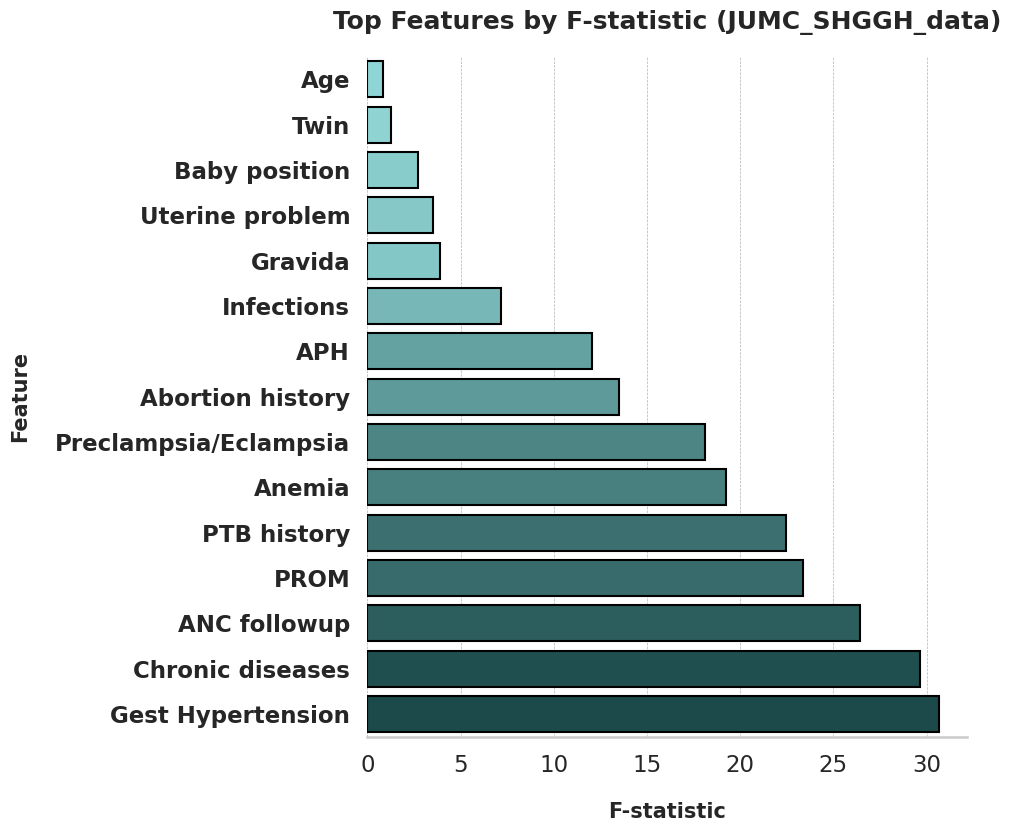

In [ ]:
# -----------------------------
# Data preparation
# -----------------------------
X_train = JUMC_SHGGH_data.drop('Outcome', axis=1)
y_train = JUMC_SHGGH_data['Outcome']

f_stats, p_values = f_classif(X_train, y_train)

f_stats_df = pd.DataFrame({
    'Feature': X_train.columns,
    'F-statistic': f_stats,
    'P-value': p_values
}).sort_values('F-statistic', ascending=False)

# Clean feature names
def clean_feature_name(name):
    name = name.replace("_", " ")
    name = re.sub(r"\d+$", "", name)
    return name.strip()

f_stats_df["Clean Feature"] = f_stats_df["Feature"].apply(clean_feature_name)

# Special handling for Baby position
f_stats_df["Clean Feature"] = f_stats_df["Clean Feature"].replace({
    "Baby position 0": None,
    "Baby position 2": "Baby position"
})

f_stats_df = f_stats_df[f_stats_df["Clean Feature"].notnull()]
f_stats_df = f_stats_df.drop_duplicates(subset=["Clean Feature"], keep="first")

# -----------------------------
# Visualization
# -----------------------------
sns.set(style="whitegrid", context="talk")

top_n = 15
plot_df = f_stats_df.head(top_n).iloc[::-1]  # reverse for barh

# Normalize F-statistics for color mapping
norm = plt.Normalize(plot_df["F-statistic"].min(), plot_df["F-statistic"].max())

# Custom color gradient from #145252 to #85e0e0
cmap = mcolors.LinearSegmentedColormap.from_list("teal_gradient", ["#85e0e0", "#145252"])

# Map F-statistic values to color gradient
colors = [cmap(norm(val)) for val in plot_df["F-statistic"]]

# Plot
plt.figure(figsize=(10, 8))

ax = sns.barplot(
    x="F-statistic",
    y="Clean Feature",
    data=plot_df,
    palette=colors,
    edgecolor="black"
)

# Titles & labels
ax.set_title("Top Features by F-statistic (JUMC_SHGGH_data)", fontsize=18, fontweight="bold", pad=20)
ax.set_xlabel("F-statistic", fontsize=15, fontweight="bold", labelpad=18)
ax.set_ylabel("Feature", fontsize=15, fontweight="bold", labelpad=18)

# Bold y-axis tick labels
ax.set_yticklabels([t.get_text() for t in ax.get_yticklabels()], fontweight="bold")

# Remove spines
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

# Grid styling
ax.xaxis.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.6)
ax.yaxis.grid(False)

# Adjust layout
plt.subplots_adjust(left=0.35, right=0.95, top=0.9, bottom=0.05)

# -----------------------------
# Save high-quality figure
# -----------------------------
plt.savefig("f_statistic_gradient_graph_JUMC_SHGGH.tiff", dpi=600, bbox_inches="tight")
plt.savefig("f_statistic_gradient_feature_importance_JUMC_SHGGH.png", dpi=600, bbox_inches="tight")

plt.show()


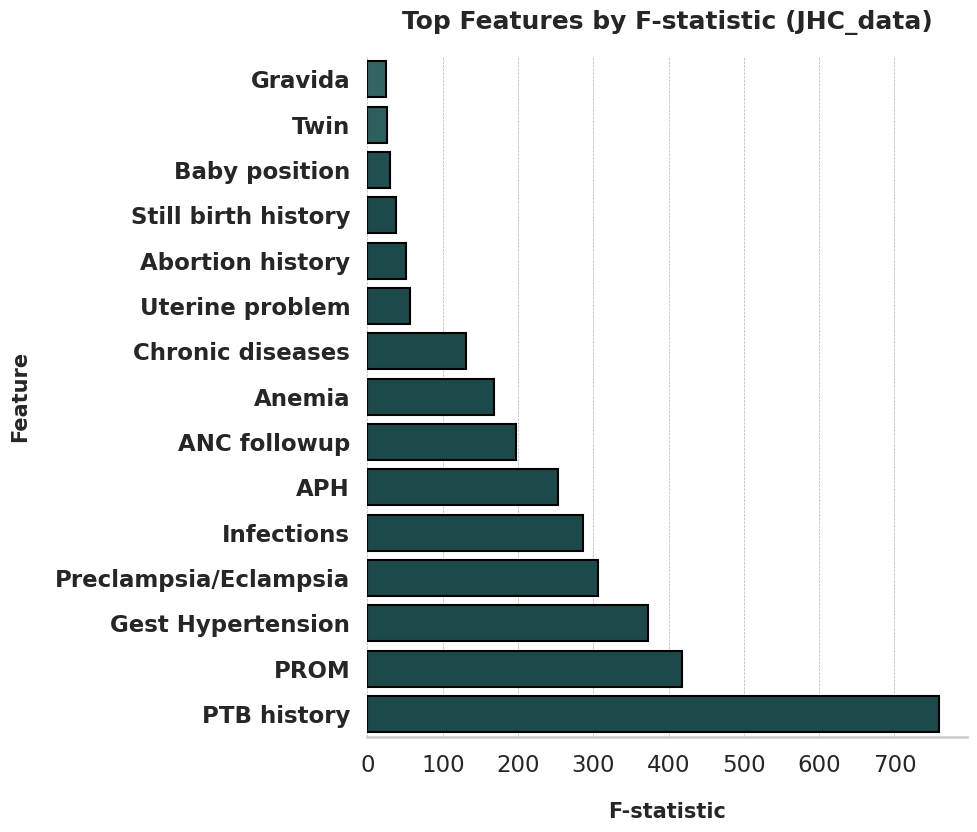

In [ ]:
# -----------------------------
# Data preparation
# -----------------------------
X_test = JHC_data.drop('Outcome', axis=1)
y_test = JHC_data['Outcome']

f_stats, p_values = f_classif(X_test, y_test)

f_stats_df = pd.DataFrame({
    'Feature': X_test.columns,
    'F-statistic': f_stats,
    'P-value': p_values
}).sort_values('F-statistic', ascending=False)

# Clean feature names
f_stats_df["Clean Feature"] = f_stats_df["Feature"].apply(clean_feature_name)

# Special handling for Baby position
f_stats_df["Clean Feature"] = f_stats_df["Clean Feature"].replace({
    "Baby position 0": None,
    "Baby position 2": "Baby position"
})

f_stats_df = f_stats_df[f_stats_df["Clean Feature"].notnull()]
f_stats_df = f_stats_df.drop_duplicates(subset=["Clean Feature"], keep="first")

# -----------------------------
# Visualization
# -----------------------------
plot_df = f_stats_df.head(top_n).iloc[::-1]  # reverse for barh
colors = [cmap(norm(val)) for val in plot_df["F-statistic"]]

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x="F-statistic",
    y="Clean Feature",
    data=plot_df,
    palette=colors,
    edgecolor="black"
)

ax.set_title("Top Features by F-statistic (JHC_data)", fontsize=18, fontweight="bold", pad=20)
ax.set_xlabel("F-statistic", fontsize=15, fontweight="bold", labelpad=18)
ax.set_ylabel("Feature", fontsize=15, fontweight="bold", labelpad=18)
ax.set_yticklabels([t.get_text() for t in ax.get_yticklabels()], fontweight="bold")

for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

ax.xaxis.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.6)
ax.yaxis.grid(False)

plt.subplots_adjust(left=0.35, right=0.95, top=0.9, bottom=0.05)

plt.savefig("f_statistic_gradient_graph_JHC.tiff", dpi=600, bbox_inches="tight")
plt.savefig("f_statistic_gradient_feature_importance_JHC.png", dpi=600, bbox_inches="tight")

plt.show()


In [ ]:
# -----------------------------
# Display F-statistics table
# -----------------------------
# Prepare and display a clean table of all features

f_stats_table = f_stats_df[["Clean Feature", "F-statistic", "P-value"]] \
    .sort_values("F-statistic", ascending=False)

# Display in full (without index)
print(f_stats_table.to_string(index=False))

        Clean Feature  F-statistic       P-value
          PTB history   759.018830 8.324976e-130
                 PROM   417.434515  7.845222e-80
    Gest Hypertension   372.126150  2.052336e-72
Preclampsia/Eclampsia   306.345953  2.995017e-61
           Infections   286.035175  1.056502e-57
                  APH   253.392104  6.765111e-52
         ANC followup   197.603884  1.176159e-41
               Anemia   168.226542  4.307641e-36
     Chronic diseases   131.018547  7.314091e-29
      Uterine problem    56.296006  1.211823e-13
     Abortion history    51.290492  1.387680e-12
  Still birth history    38.138396  9.011995e-10
        Baby position    29.517444  6.708184e-08
                 Twin    26.219445  3.548323e-07
              Gravida    24.778058  7.373881e-07
            Residence    13.257221  2.831274e-04
                  Age     8.510088  3.597755e-03
       Prev C section     7.561127  6.053859e-03
      FHR Abnormality     6.145112  1.331452e-02


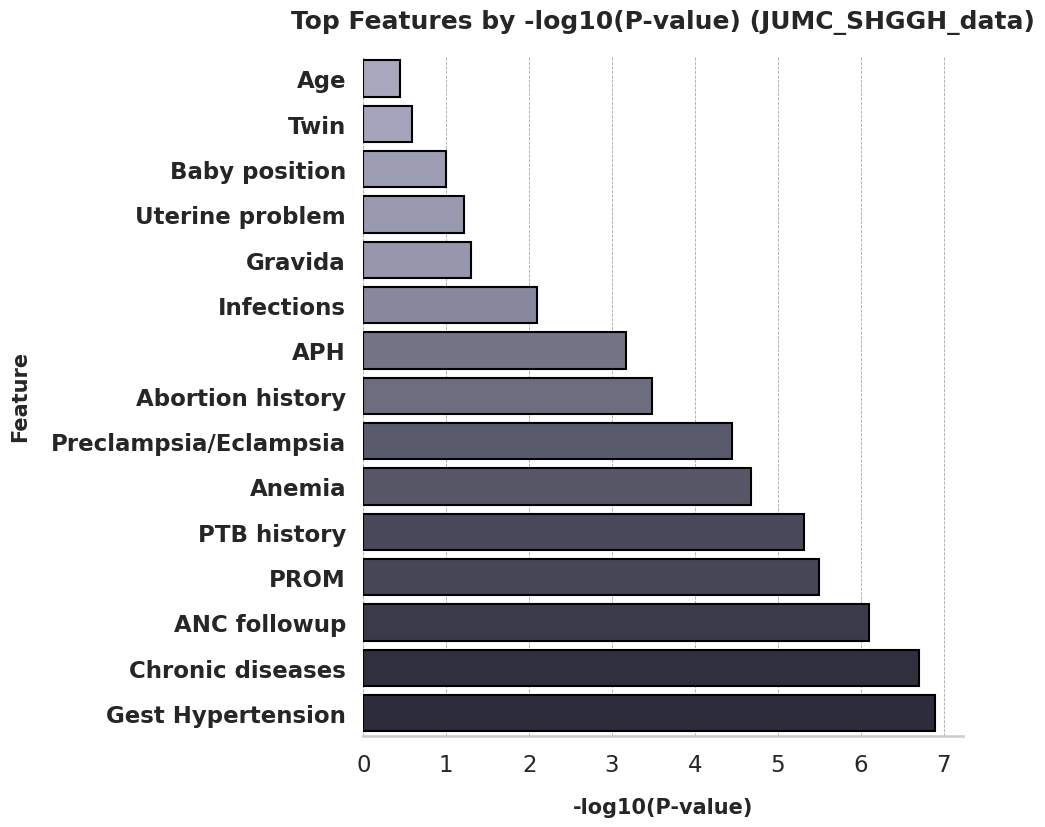

In [ ]:
# -----------------------------
# Compute F-statistics and p-values
# -----------------------------
X_train = JUMC_SHGGH_data.drop('Outcome', axis=1)
y_train = JUMC_SHGGH_data['Outcome']

f_stats, p_values = f_classif(X_train, y_train)

f_stats_df = pd.DataFrame({
    'Feature': X_train.columns,
    'F-statistic': f_stats,
    'P-value': p_values
})

# -----------------------------
# Feature name cleaning
# -----------------------------
def clean_feature_name(name):
    name = name.replace("_", " ")
    name = re.sub(r"\d+$", "", name)
    return name.strip()

p_values_df = f_stats_df.copy()
p_values_df["Clean Feature"] = p_values_df["Feature"].apply(clean_feature_name)

# Special handling for Baby position
p_values_df["Clean Feature"] = p_values_df["Clean Feature"].replace({
    "Baby position 0": None,
    "Baby position 2": "Baby position"
})

# Drop nulls and duplicates
p_values_df = p_values_df[p_values_df["Clean Feature"].notnull()]
p_values_df = p_values_df.drop_duplicates(subset=["Clean Feature"], keep="first")

# -----------------------------
# -log10 transform of p-values
# -----------------------------
p_values_df["-log10(P-value)"] = -np.log10(p_values_df["P-value"])
p_values_df = p_values_df.sort_values("-log10(P-value)", ascending=False)

# -----------------------------
# Visualization
# -----------------------------
sns.set(style="whitegrid", context="talk")

top_n = 15
plot_df = p_values_df.head(top_n).iloc[::-1]  # reverse for horizontal bar plot

# Normalize values for color mapping
norm = plt.Normalize(plot_df["-log10(P-value)"].min(), plot_df["-log10(P-value)"].max())

# Custom green gradient: light to dark
cmap = mcolors.LinearSegmentedColormap.from_list("green_gradient", ["#a3a3c2", "#29293d"])
colors = [cmap(norm(val)) for val in plot_df["-log10(P-value)"]]

# Plot
plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x="-log10(P-value)",
    y="Clean Feature",
    data=plot_df,
    palette=colors,
    edgecolor="black"
)

ax.set_title("Top Features by -log10(P-value) (JUMC_SHGGH_data)", fontsize=18, fontweight="bold", pad=20)
ax.set_xlabel("-log10(P-value)", fontsize=15, fontweight="bold", labelpad=15)
ax.set_ylabel("Feature", fontsize=15, fontweight="bold", labelpad=15)

ax.set_yticklabels([t.get_text() for t in ax.get_yticklabels()], fontweight="bold")

for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

ax.xaxis.grid(True, linestyle="--", linewidth=0.6, color="gray", alpha=0.7)
ax.yaxis.grid(False)

plt.subplots_adjust(left=0.35, right=0.95, top=0.9, bottom=0.05)

plt.savefig("p_value_JUMC_SHGGH.tiff", dpi=600, bbox_inches="tight")
plt.savefig("p_value_feature_significance_log_JUMC_SHGGH.png", dpi=600, bbox_inches="tight")

plt.show()


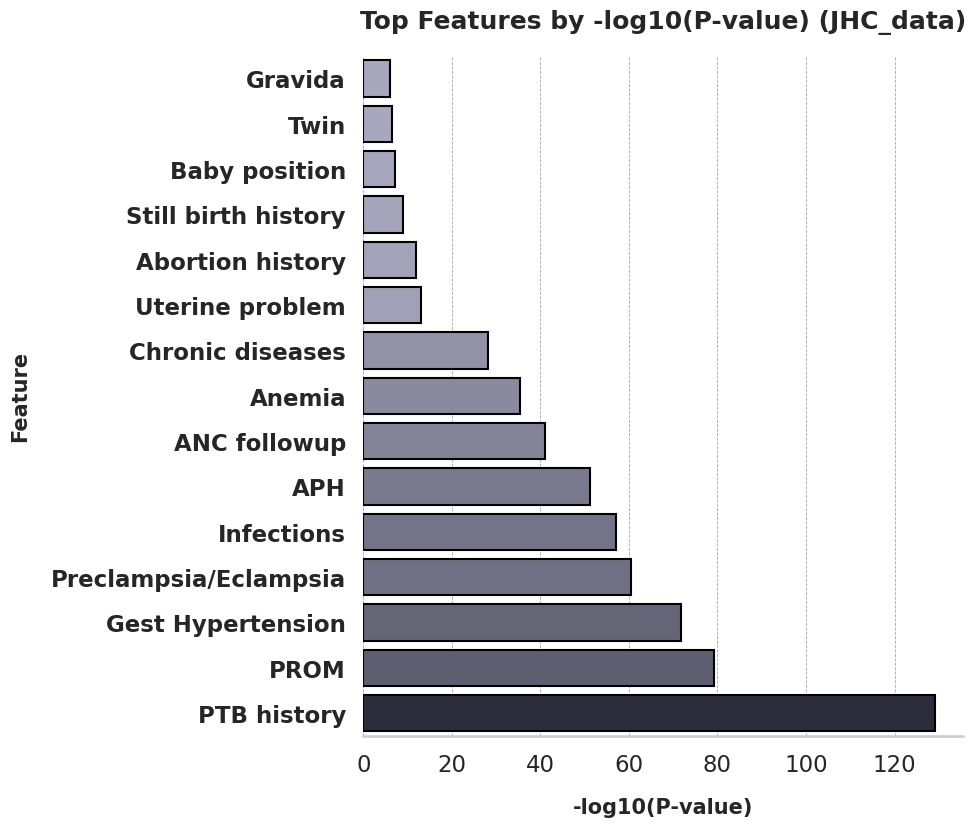

In [ ]:
# -----------------------------
# Compute F-statistics and p-values
# -----------------------------
X_test = JHC_data.drop('Outcome', axis=1)
y_test = JHC_data['Outcome']

f_stats, p_values = f_classif(X_test, y_test)

f_stats_df = pd.DataFrame({
    'Feature': X_test.columns,
    'F-statistic': f_stats,
    'P-value': p_values
})

# -----------------------------
# Feature name cleaning
# -----------------------------
p_values_df = f_stats_df.copy()
p_values_df["Clean Feature"] = p_values_df["Feature"].apply(clean_feature_name)

# Special handling for Baby position
p_values_df["Clean Feature"] = p_values_df["Clean Feature"].replace({
    "Baby position 0": None,
    "Baby position 2": "Baby position"
})

# Drop nulls and duplicates
p_values_df = p_values_df[p_values_df["Clean Feature"].notnull()]
p_values_df = p_values_df.drop_duplicates(subset=["Clean Feature"], keep="first")

# -----------------------------
# -log10 transform of p-values
# -----------------------------
p_values_df["-log10(P-value)"] = -np.log10(p_values_df["P-value"])
p_values_df = p_values_df.sort_values("-log10(P-value)", ascending=False)

# -----------------------------
# Visualization
# -----------------------------
top_n = 15
plot_df = p_values_df.head(top_n).iloc[::-1]

norm = plt.Normalize(plot_df["-log10(P-value)"].min(), plot_df["-log10(P-value)"].max())
cmap = mcolors.LinearSegmentedColormap.from_list("green_gradient", ["#a3a3c2", "#29293d"])
colors = [cmap(norm(val)) for val in plot_df["-log10(P-value)"]]

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x="-log10(P-value)",
    y="Clean Feature",
    data=plot_df,
    palette=colors,
    edgecolor="black"
)

ax.set_title("Top Features by -log10(P-value) (JHC_data)", fontsize=18, fontweight="bold", pad=20)
ax.set_xlabel("-log10(P-value)", fontsize=15, fontweight="bold", labelpad=15)
ax.set_ylabel("Feature", fontsize=15, fontweight="bold", labelpad=15)

ax.set_yticklabels([t.get_text() for t in ax.get_yticklabels()], fontweight="bold")

for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

ax.xaxis.grid(True, linestyle="--", linewidth=0.6, color="gray", alpha=0.7)
ax.yaxis.grid(False)

plt.subplots_adjust(left=0.35, right=0.95, top=0.9, bottom=0.05)

plt.savefig("p_value_JHC.tiff", dpi=600, bbox_inches="tight")
plt.savefig("p_value_feature_significance_log_JHC.png", dpi=600, bbox_inches="tight")

plt.show()


In [ ]:
# Prepare a DataFrame with all features and their p-values and cleaned names
all_p_values_table_JUMC = f_stats_df.copy()
all_p_values_table_JUMC["Features"] = all_p_values_table_JUMC["Feature"].apply(clean_feature_name)

# Drop nulls and duplicates on cleaned feature
all_p_values_table_JUMC = all_p_values_table_JUMC[all_p_values_table_JUMC["Features"].notnull()]
all_p_values_table_JUMC = all_p_values_table_JUMC.drop_duplicates(subset=["Features"], keep="first")

# Select columns and sort by p-value ascending
all_p_values_table_JUMC = all_p_values_table_JUMC[["Features", "P-value"]].sort_values("P-value")

# Display the table
print("All features with p-values (JUMC_SHGGH_data):")
print(all_p_values_table_JUMC.to_string(index=False))


All features with p-values (JUMC_SHGGH_data):
             Features       P-value
          PTB history 8.324976e-130
                 PROM  7.845222e-80
    Gest Hypertension  2.052336e-72
Preclampsia/Eclampsia  2.995017e-61
           Infections  1.056502e-57
                  APH  6.765111e-52
         ANC followup  1.176159e-41
               Anemia  4.307641e-36
     Chronic diseases  7.314091e-29
      Uterine problem  1.211823e-13
     Abortion history  1.387680e-12
  Still birth history  9.011995e-10
        Baby position  6.708184e-08
                 Twin  3.548323e-07
              Gravida  7.373881e-07
            Residence  2.831274e-04
                  Age  3.597755e-03
       Prev C section  6.053859e-03
      FHR Abnormality  1.331452e-02


In [ ]:
# Prepare a DataFrame with all features and their p-values and cleaned names
all_p_values_table_JHC = f_stats_df.copy()
all_p_values_table_JHC["Features"] = all_p_values_table_JHC["Feature"].apply(clean_feature_name)

# Drop nulls and duplicates on cleaned feature
all_p_values_table_JHC = all_p_values_table_JHC[all_p_values_table_JHC["Features"].notnull()]
all_p_values_table_JHC = all_p_values_table_JHC.drop_duplicates(subset=["Features"], keep="first")

# Select columns and sort by p-value ascending
all_p_values_table_JHC = all_p_values_table_JHC[["Features", "P-value"]].sort_values("P-value")

# Display the table
print("All features with p-values (JHC_data):")
print(all_p_values_table_JHC.to_string(index=False))


All features with p-values (JHC_data):
             Features       P-value
          PTB history 8.324976e-130
                 PROM  7.845222e-80
    Gest Hypertension  2.052336e-72
Preclampsia/Eclampsia  2.995017e-61
           Infections  1.056502e-57
                  APH  6.765111e-52
         ANC followup  1.176159e-41
               Anemia  4.307641e-36
     Chronic diseases  7.314091e-29
      Uterine problem  1.211823e-13
     Abortion history  1.387680e-12
  Still birth history  9.011995e-10
        Baby position  6.708184e-08
                 Twin  3.548323e-07
              Gravida  7.373881e-07
            Residence  2.831274e-04
                  Age  3.597755e-03
       Prev C section  6.053859e-03
      FHR Abnormality  1.331452e-02


###Exploratory Data Analysis

####Univariate

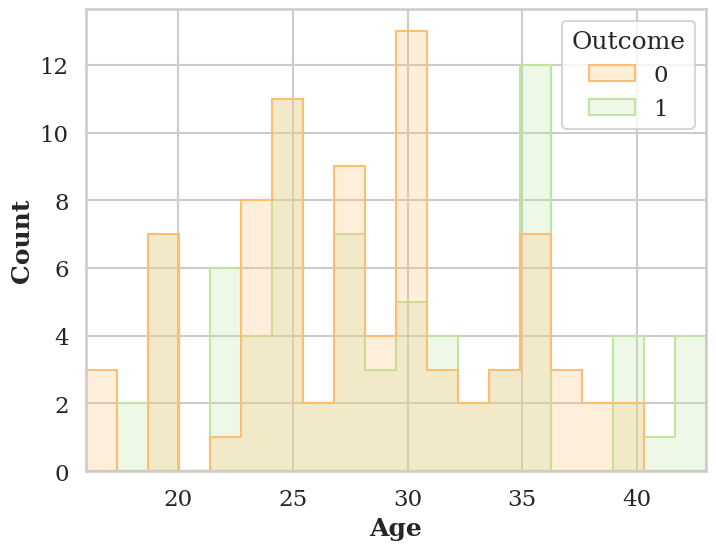

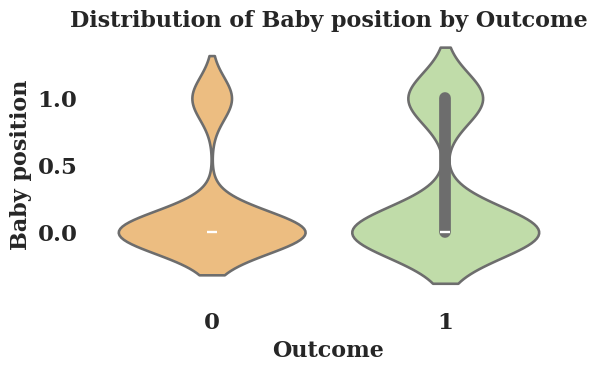

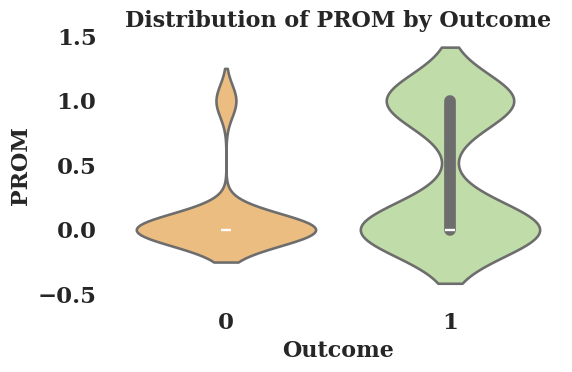

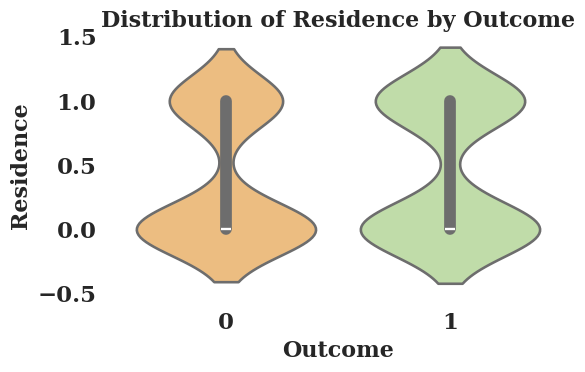

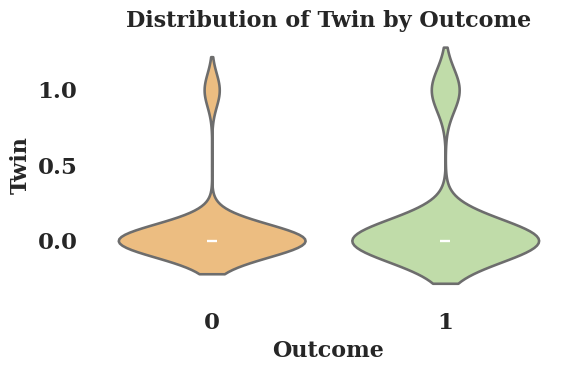

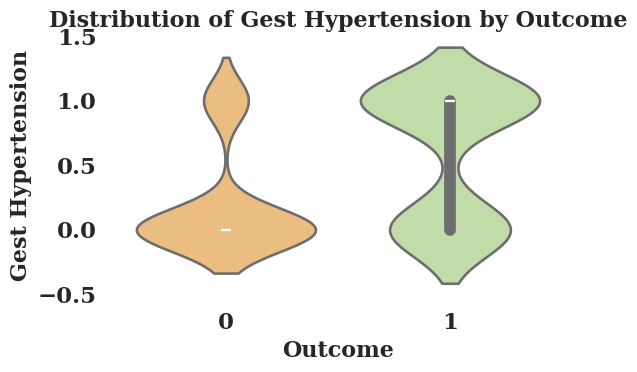

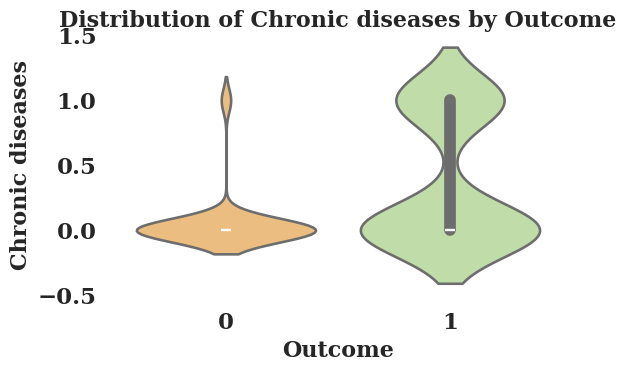

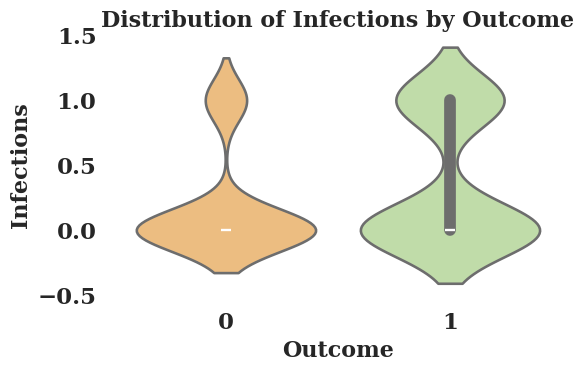

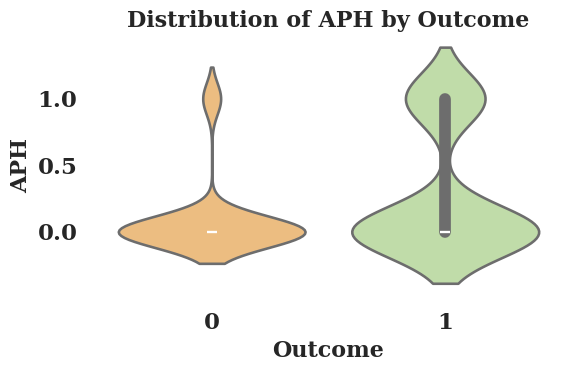

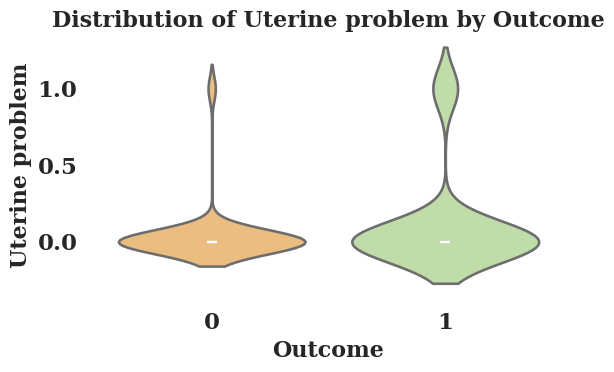

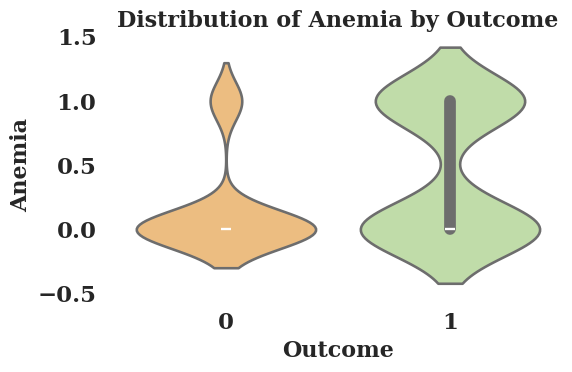

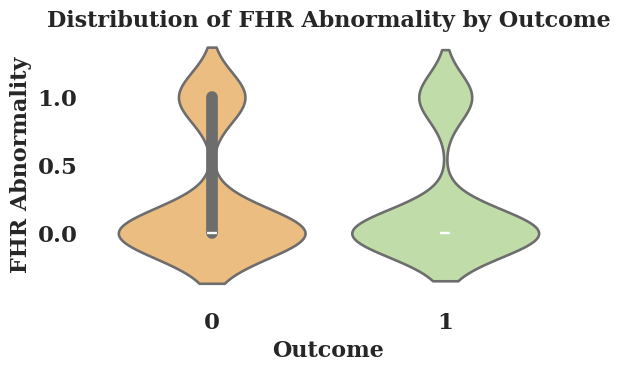

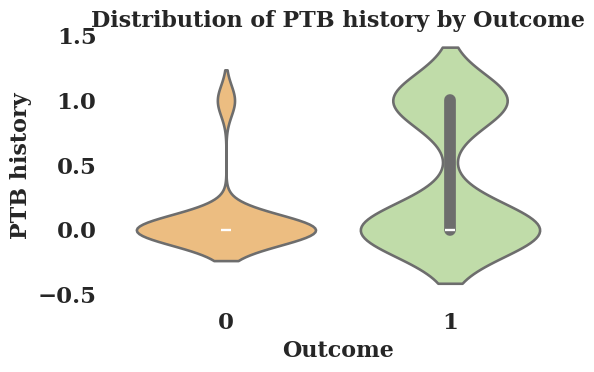

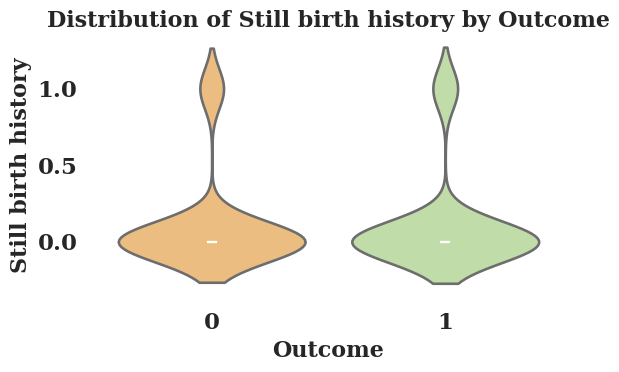

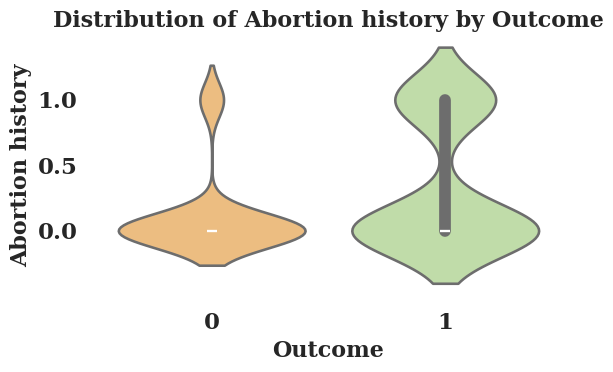

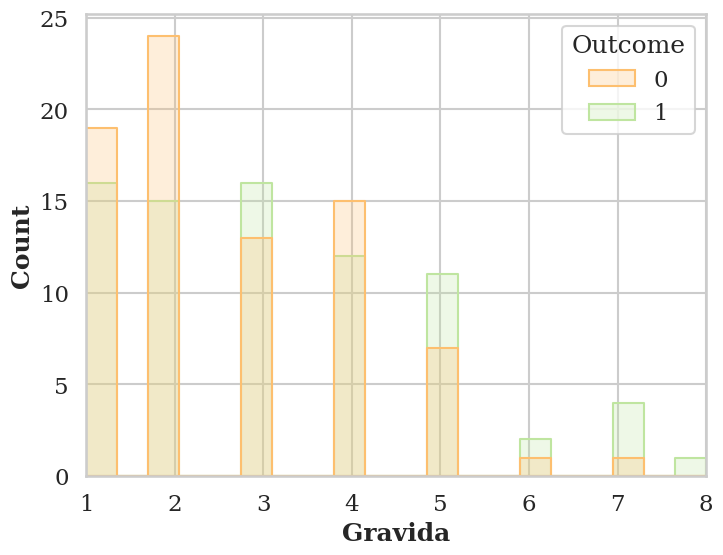

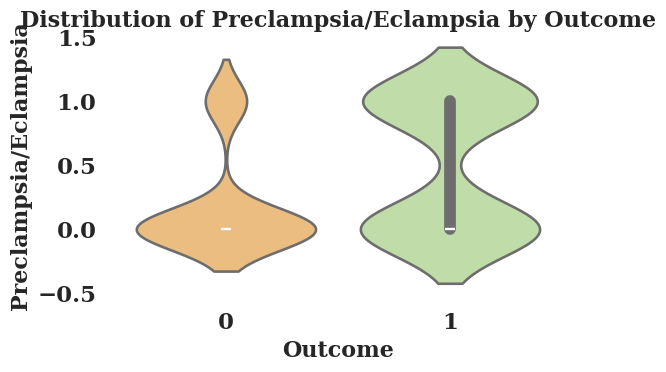

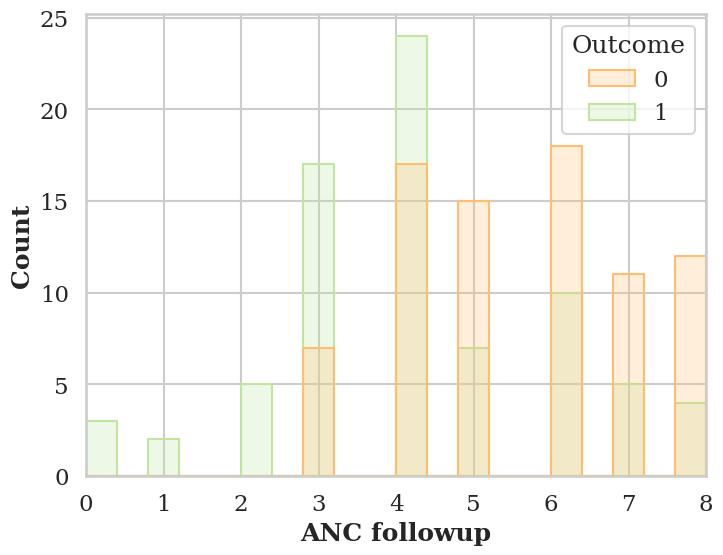

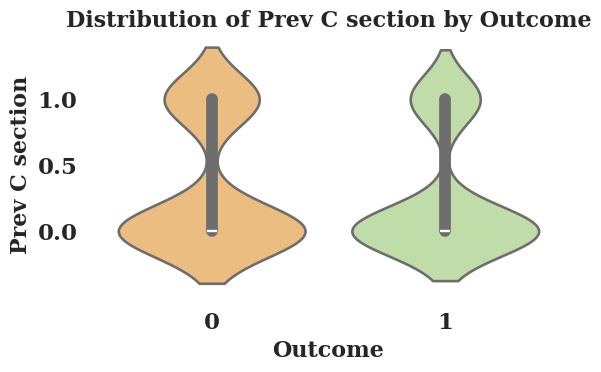

In [ ]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    "axes.labelweight": "bold",
    "axes.titlesize": 16,
    "axes.titleweight": "bold"
})

data = JUMC_SHGGH_data.copy()  # Use JUMC_SHGGH_data
output_dir = "JUMC_SHGGH_feature_vs_outcome_figures"
os.makedirs(output_dir, exist_ok=True)

def clean_filename(s):
    return re.sub(r'[\\/*?:"<>|,]', "_", s).replace(" ", "_")

numerical_cols = data.select_dtypes(include=np.number).columns.tolist()
if "Outcome" in numerical_cols:
    numerical_cols.remove("Outcome")

for col in numerical_cols:
    unique_vals = data[col].dropna().unique()
    max_val = data[col].max()

    # Small-range integer → Violin plot
    if np.allclose(unique_vals, unique_vals.astype(int)) and max_val <= 3:
        plt.figure(figsize=(6, 4))
        ax = sns.violinplot(
            x="Outcome",
            y=col,
            data=data,
            palette="Spectral",
            inner="box"
        )
        plt.title(f'Distribution of {col} by Outcome', fontsize=16, fontweight='bold')
        plt.xlabel("Outcome", fontsize=16, fontweight='bold')
        plt.ylabel(col, fontsize=16, fontweight='bold')
        plt.xticks(fontweight='bold')
        plt.yticks(fontweight='bold')
        sns.despine(left=True, bottom=True)
        ax.grid(False)

        fname = os.path.join(output_dir, f"{clean_filename(col)}_violin_vs_outcome.tiff")
        plt.tight_layout()
        plt.savefig(fname, dpi=600, bbox_inches="tight")
        plt.show()
        plt.close()

    # Continuous → Histogram
    else:
        plt.figure(figsize=(8, 6))
        ax = sns.histplot(
            data=data,
            x=col,
            hue="Outcome",
            palette="Spectral",
            element="step",
            stat="count",
            common_norm=False,
            bins=20
        )

        counts = data.groupby(["Outcome", col]).size().reset_index(name="count")
        nonzero_vals = counts.loc[counts["count"] > 0, col].unique()
        ax.set_xlim(min(nonzero_vals), max(nonzero_vals))


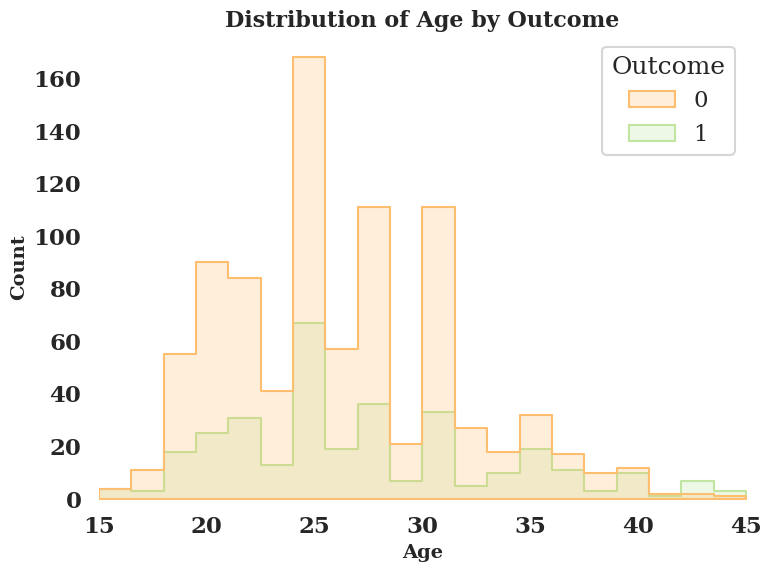

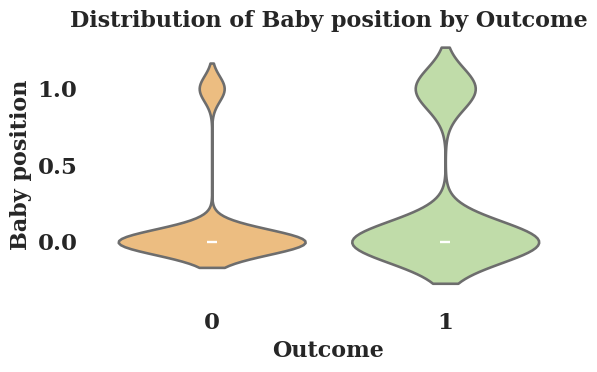

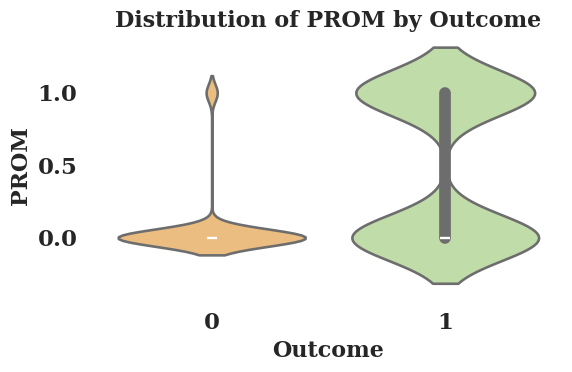

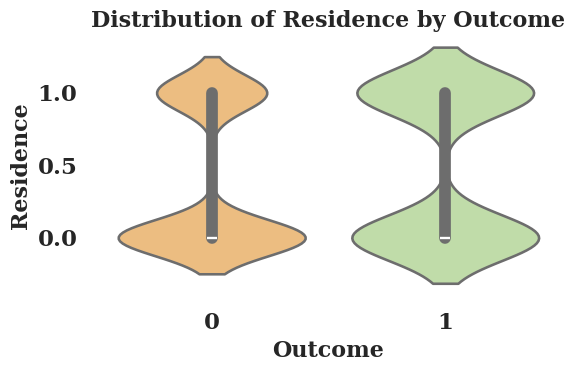

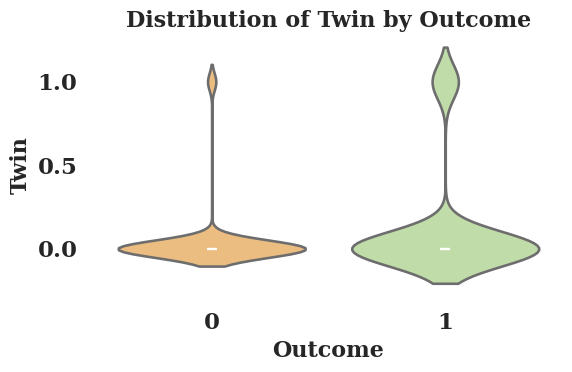

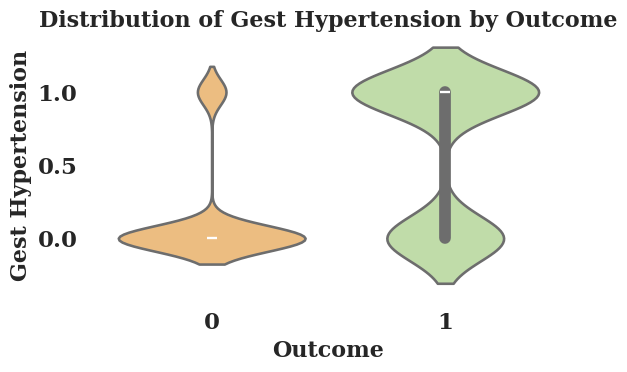

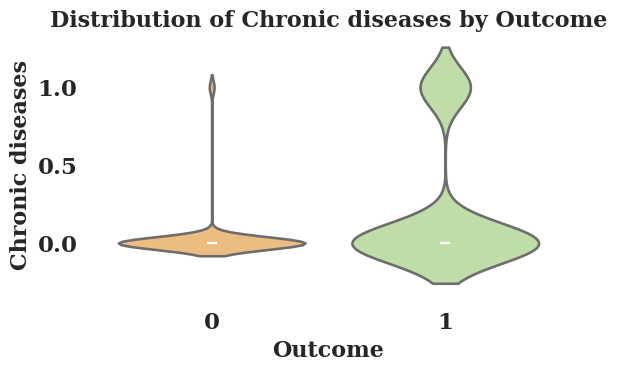

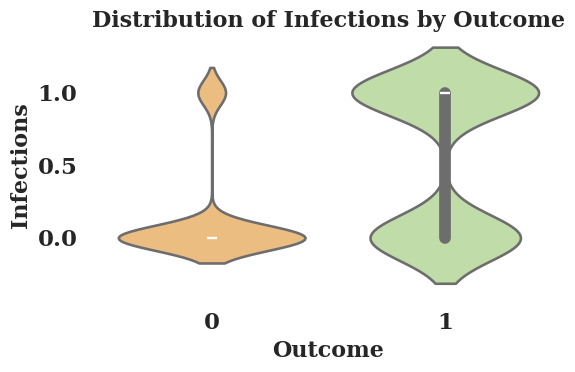

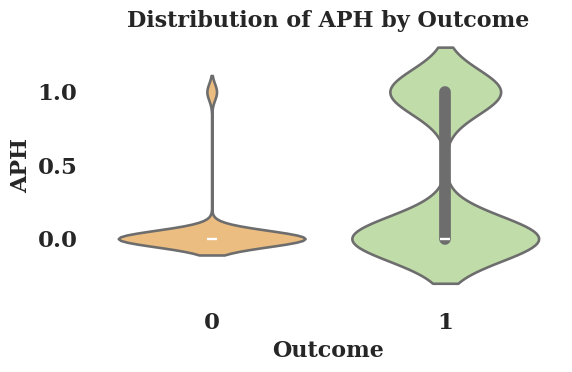

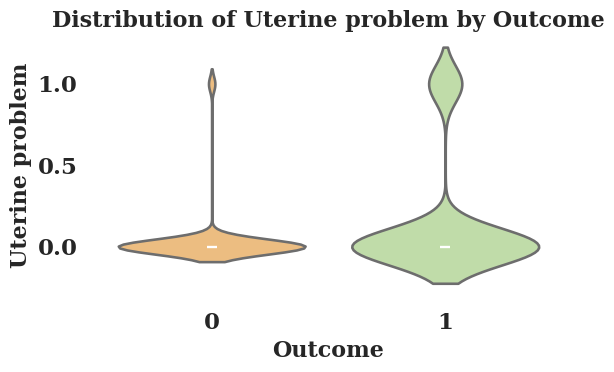

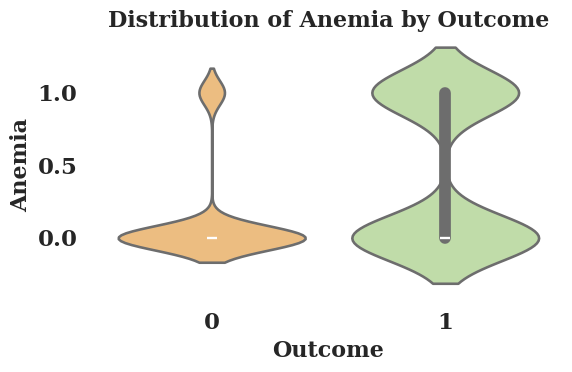

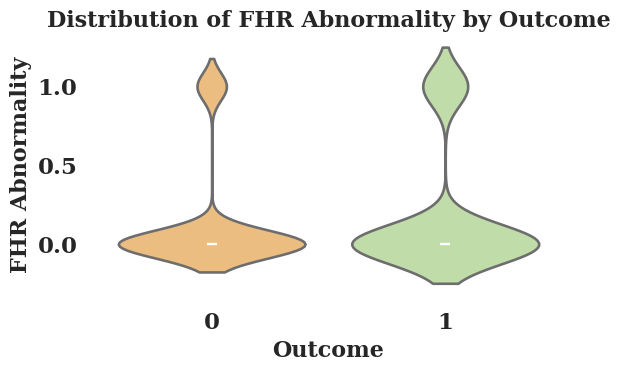

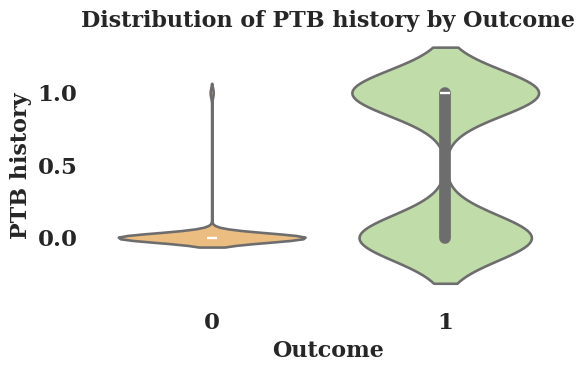

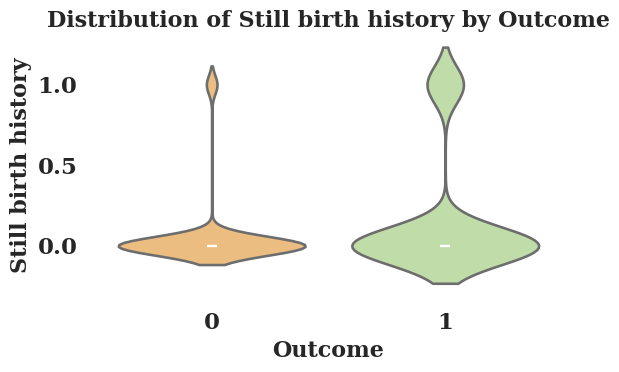

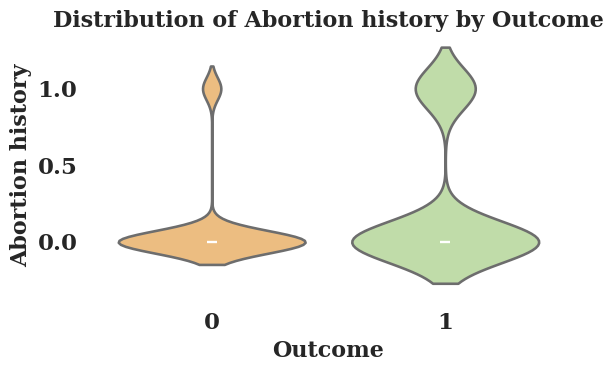

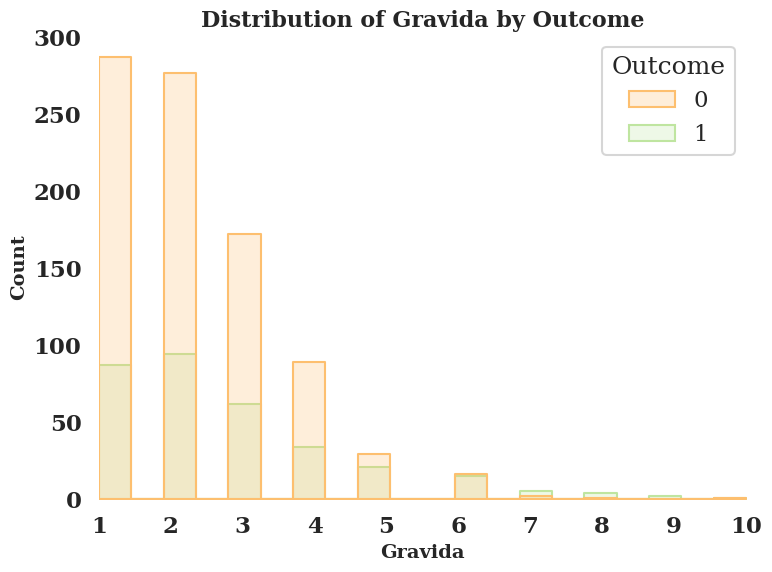

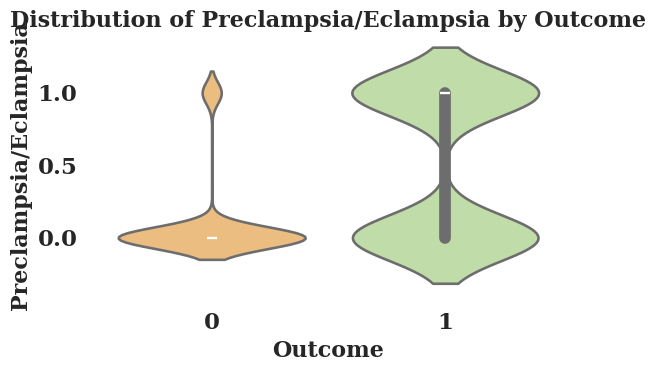

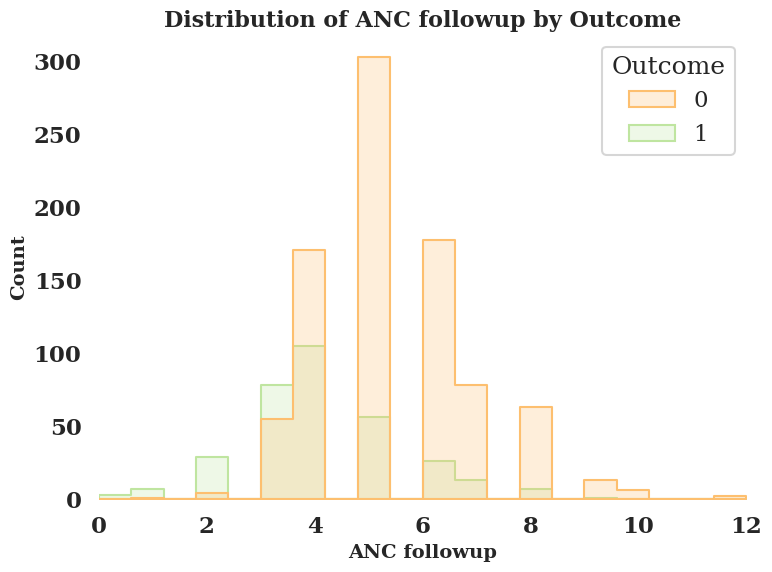

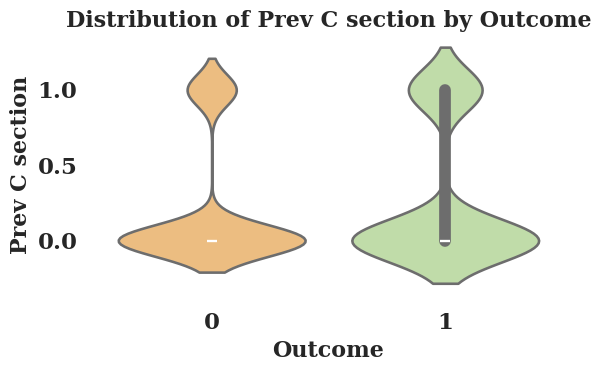

✅ All JHC_data figures saved in: JHC_feature_vs_outcome_figures


In [ ]:
data = JHC_data.copy()  # Use JHC_data
output_dir = "JHC_feature_vs_outcome_figures"
os.makedirs(output_dir, exist_ok=True)

numerical_cols = data.select_dtypes(include=np.number).columns.tolist()
if "Outcome" in numerical_cols:
    numerical_cols.remove("Outcome")

for col in numerical_cols:
    unique_vals = data[col].dropna().unique()
    max_val = data[col].max()

    if np.allclose(unique_vals, unique_vals.astype(int)) and max_val <= 3:
        plt.figure(figsize=(6, 4))
        ax = sns.violinplot(
            x="Outcome",
            y=col,
            data=data,
            palette="Spectral",
            inner="box"
        )
        plt.title(f'Distribution of {col} by Outcome', fontsize=16, fontweight='bold')
        plt.xlabel("Outcome", fontsize=16, fontweight='bold')
        plt.ylabel(col, fontsize=16, fontweight='bold')
        plt.xticks(fontweight='bold')
        plt.yticks(fontweight='bold')
        sns.despine(left=True, bottom=True)
        ax.grid(False)

        fname = os.path.join(output_dir, f"{clean_filename(col)}_violin_vs_outcome.tiff")
        plt.tight_layout()
        plt.savefig(fname, dpi=600, bbox_inches="tight")
        plt.show()
        plt.close()
    else:
        plt.figure(figsize=(8, 6))
        ax = sns.histplot(
            data=data,
            x=col,
            hue="Outcome",
            palette="Spectral",
            element="step",
            stat="count",
            common_norm=False,
            bins=20
        )

        counts = data.groupby(["Outcome", col]).size().reset_index(name="count")
        nonzero_vals = counts.loc[counts["count"] > 0, col].unique()
        ax.set_xlim(min(nonzero_vals), max(nonzero_vals))

        plt.title(f'Distribution of {col} by Outcome', fontsize=16, fontweight='bold')
        plt.xlabel(col, fontsize=14, fontweight='bold')
        plt.ylabel('Count', fontsize=14, fontweight='bold')
        plt.xticks(fontweight='bold')
        plt.yticks(fontweight='bold')
        sns.despine(left=True, bottom=True)
        ax.grid(False)

        fname = os.path.join(output_dir, f"{clean_filename(col)}_hist_vs_outcome.tiff")
        plt.tight_layout()
        plt.savefig(fname, dpi=600, bbox_inches="tight")
        plt.show()
        plt.close()

print("✅ All JHC_data figures saved in:", output_dir)


In [ ]:

# Use JUMC_SHGGH_data
data = JUMC_SHGGH_data.copy()

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Add a constant (intercept)
X = sm.add_constant(X)

# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit(disp=False)  # disp=False to suppress fitting output

# Extract Odds Ratios and 95% Confidence Intervals
odds_ratios_JUMC = pd.DataFrame({
    'OR': result.params,
    'Lower CI': result.conf_int()[0],
    'Upper CI': result.conf_int()[1]
})

# Drop intercept row
odds_ratios_JUMC = odds_ratios_JUMC.drop('const')

# Display results
print("Odds Ratios and 95% Confidence Intervals (JUMC_SHGGH_data):")
print(odds_ratios_JUMC)


Odds Ratios and 95% Confidence Intervals (JUMC_SHGGH_data):
                             OR  Lower CI  Upper CI
Age                    0.001082 -0.131424  0.133587
Baby position          0.579507 -0.746183  1.905198
PROM                   2.340035  0.895718  3.784352
Residence              0.206972 -0.999384  1.413328
Twin                   0.764602 -1.193364  2.722569
Gest Hypertension      1.932539  0.698204  3.166874
Chronic diseases       3.174268  1.402159  4.946377
Infections             0.726381 -0.579761  2.032522
APH                    1.227395 -0.341498  2.796288
Uterine problem        0.610565 -1.960298  3.181427
Anemia                 0.750736 -0.511124  2.012596
FHR Abnormality        0.450702 -0.945757  1.847160
PTB history            1.007149 -0.533834  2.548131
Still birth history   -2.042545 -4.032347 -0.052743
Abortion history       1.126250 -0.340439  2.592939
Gravida                0.102190 -0.345482  0.549862
Preclampsia/Eclampsia  1.950951  0.591377  3.310526
ANC 

In [ ]:
# Use JHC_data
data = JHC_data.copy()

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Add a constant (intercept)
X = sm.add_constant(X)

# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit(disp=False)

# Extract Odds Ratios and 95% Confidence Intervals
odds_ratios_JHC = pd.DataFrame({
    'OR': result.params,
    'Lower CI': result.conf_int()[0],
    'Upper CI': result.conf_int()[1]
})

# Drop intercept row
odds_ratios_JHC = odds_ratios_JHC.drop('const')

# Display results
print("Odds Ratios and 95% Confidence Intervals (JHC_data):")
print(odds_ratios_JHC)


Odds Ratios and 95% Confidence Intervals (JHC_data):
                             OR  Lower CI  Upper CI
Age                   -0.022151 -0.079417  0.035116
Baby position          1.054856  0.431798  1.677915
PROM                   2.593082  1.977520  3.208645
Residence              0.017123 -0.498640  0.532887
Twin                   1.536447  0.650762  2.422132
Gest Hypertension      1.419432  0.858630  1.980233
Chronic diseases       1.434381  0.401919  2.466843
Infections             1.452497  0.894063  2.010932
APH                    1.829258  1.146159  2.512357
Uterine problem        1.206386  0.155275  2.257498
Anemia                 0.979503  0.403222  1.555784
FHR Abnormality        0.281925 -0.346403  0.910254
PTB history            3.529331  2.710651  4.348011
Still birth history    0.700401 -0.185661  1.586463
Abortion history       0.899164  0.087119  1.711209
Gravida               -0.067485 -0.315314  0.180345
Preclampsia/Eclampsia  1.222777  0.615024  1.830529
ANC followu

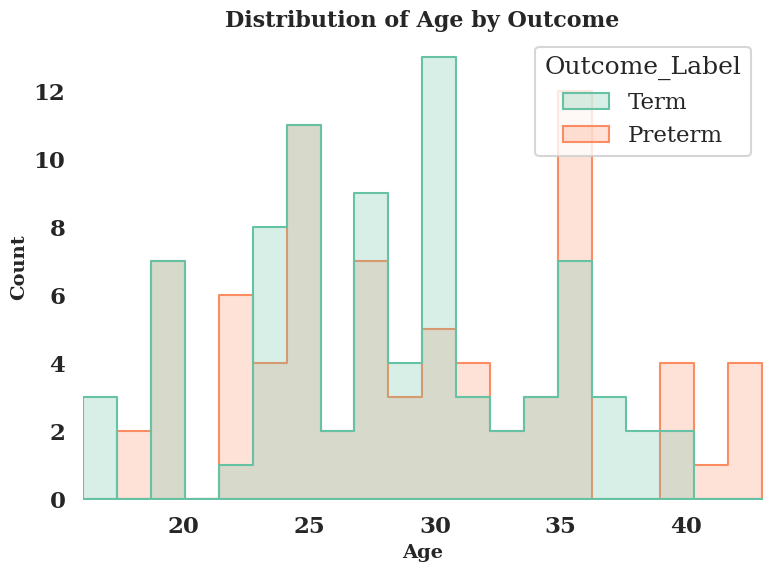

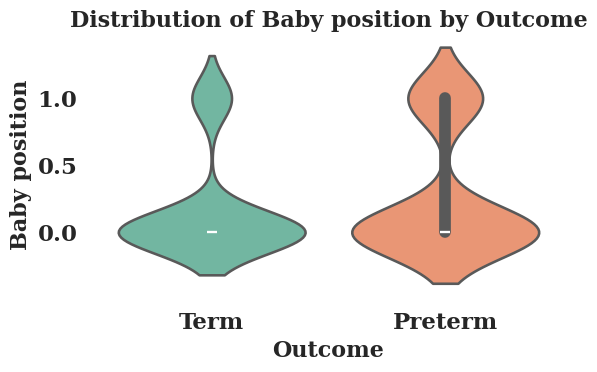

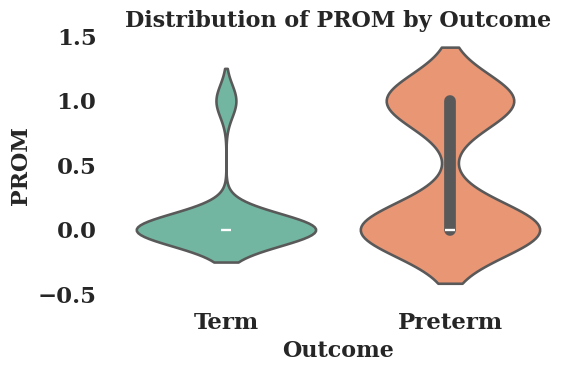

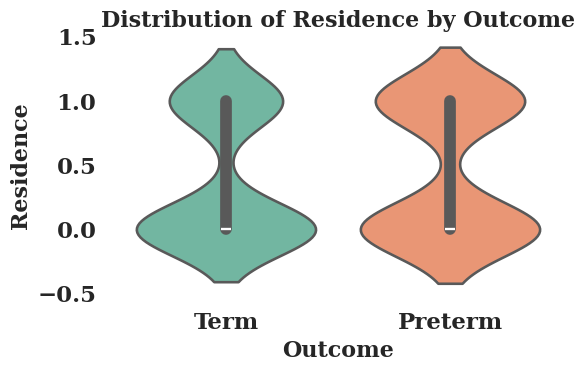

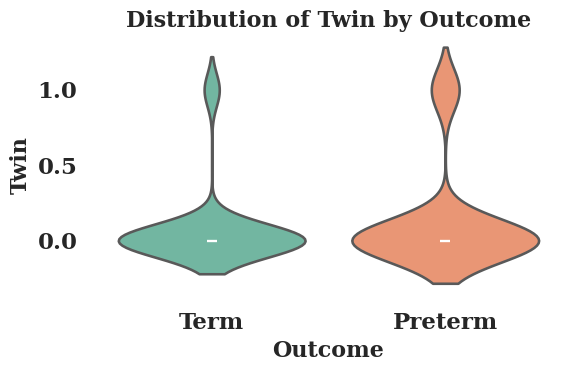

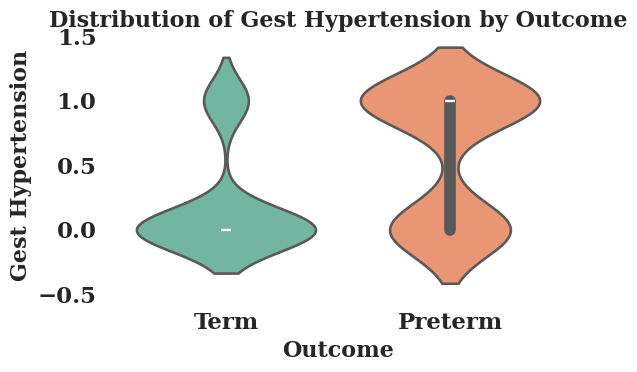

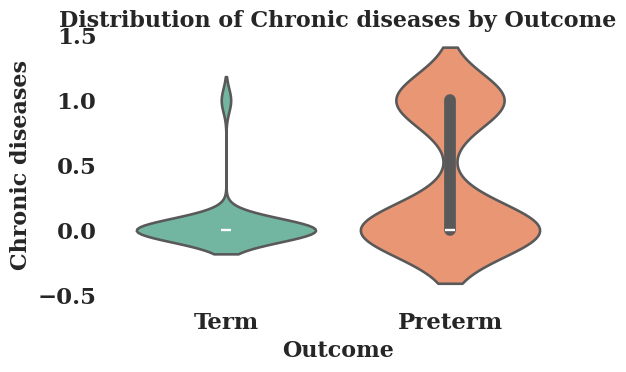

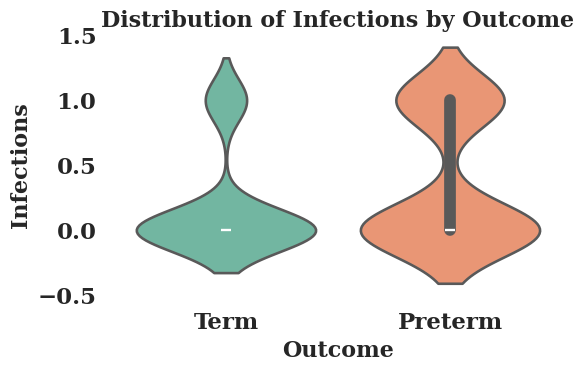

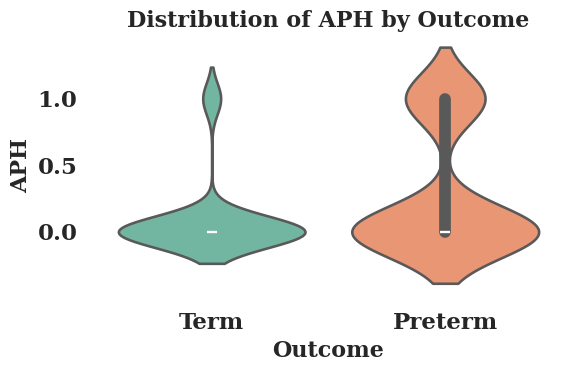

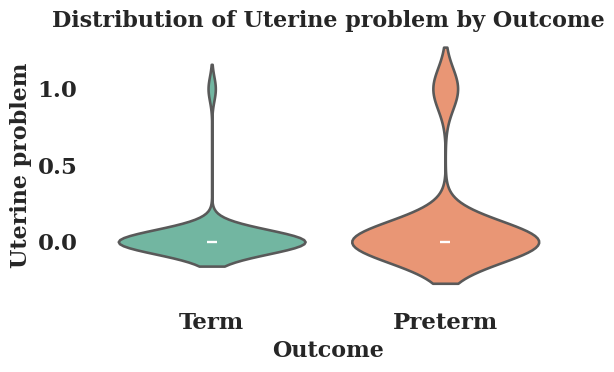

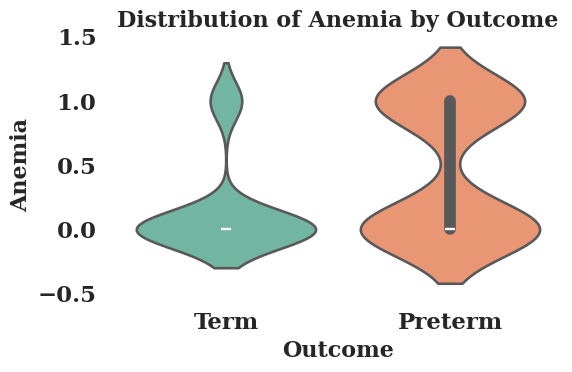

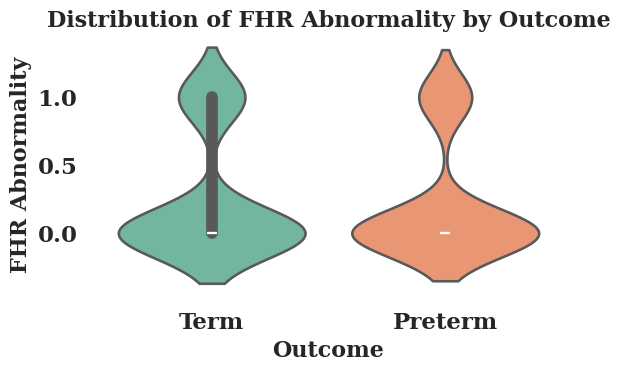

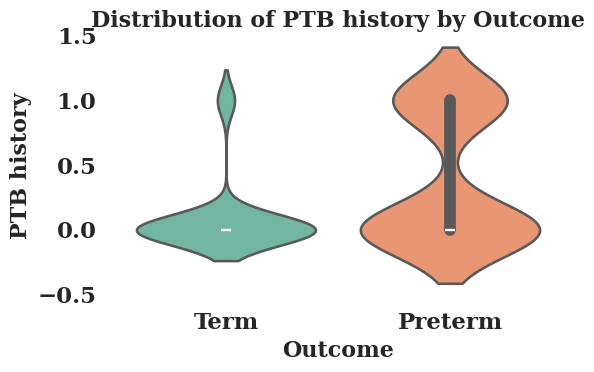

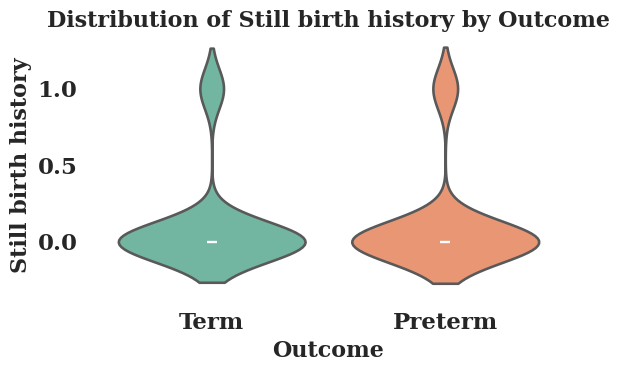

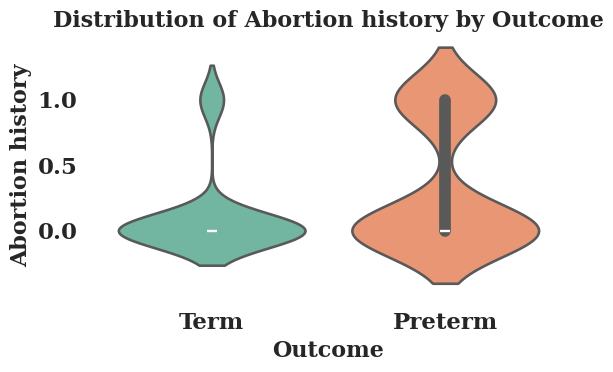

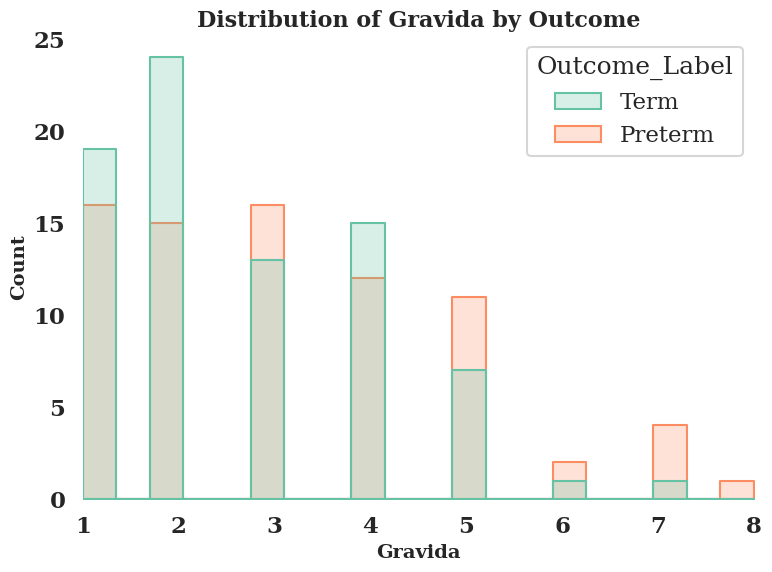

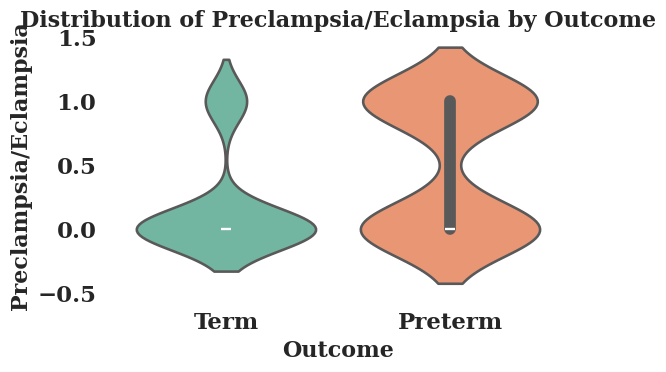

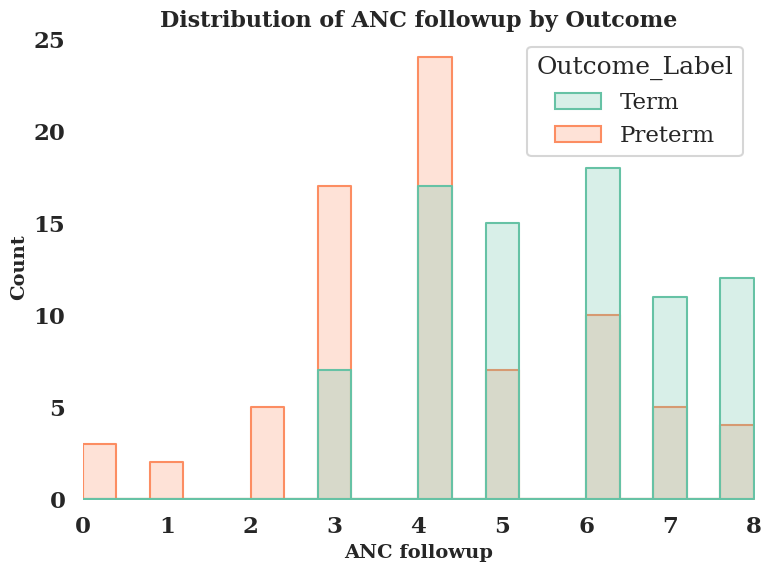

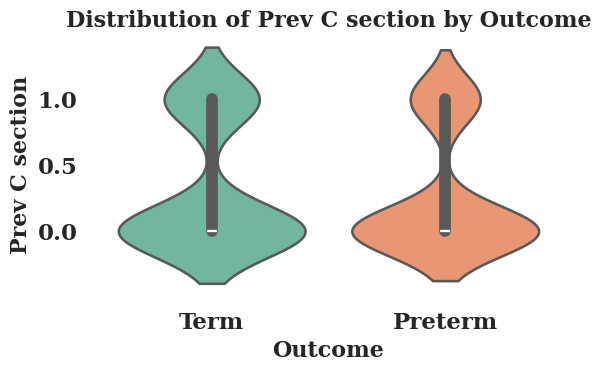

✅ All JUMC_SHGGH_data figures saved in: JUMC_SHGGH_feature_vs_outcome_figures


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use JUMC_SHGGH_data
data = JUMC_SHGGH_data.copy()

# ---------------------------------------
# Style for publication-ready figures
# ---------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    "axes.labelweight": "bold",
    "axes.titlesize": 16,
    "axes.titleweight": "bold"
})

# ---------------------------------------
# Output directory for figures
# ---------------------------------------
output_dir = "JUMC_SHGGH_feature_vs_outcome_figures"
os.makedirs(output_dir, exist_ok=True)

# ---------------------------------------
# Helper to clean filenames
# ---------------------------------------
def clean_filename(s):
    return re.sub(r'[\\/*?:"<>|,]', "_", s).replace(" ", "_")

# ---------------------------------------
# Select numeric columns (excluding Outcome)
# ---------------------------------------
numerical_cols = data.select_dtypes(include=np.number).columns.tolist()
if "Outcome" in numerical_cols:
    numerical_cols.remove("Outcome")

# Map outcome labels: 0 → Term, 1 → Preterm
data_plot = data.copy()
data_plot["Outcome_Label"] = data_plot["Outcome"].map({0: "Term", 1: "Preterm"})

# ---------------------------------------
# Generate one plot per numerical feature
# ---------------------------------------
for col in numerical_cols:
    unique_vals = data_plot[col].dropna().unique()
    max_val = data_plot[col].max()

    # Small-range integer → Violin plot
    if np.allclose(unique_vals, unique_vals.astype(int)) and max_val <= 3:
        plt.figure(figsize=(6, 4))
        ax = sns.violinplot(
            x="Outcome_Label",
            y=col,
            data=data_plot,
            palette="Set2",
            inner="box"
        )
        plt.ylabel(col, fontsize=16, fontweight='bold')
        plt.title(f'Distribution of {col} by Outcome', fontsize=16, fontweight='bold')
        plt.xlabel("Outcome", fontsize=16, fontweight='bold')
        plt.xticks(fontweight='bold')
        plt.yticks(fontweight='bold')
        sns.despine(left=True, bottom=True)
        ax.grid(False)

        fname = os.path.join(output_dir, f"{clean_filename(col)}_violin_vs_outcome.tiff")
        plt.tight_layout()
        plt.savefig(fname, dpi=600, bbox_inches="tight")
        plt.show()
        plt.close()

    # Continuous → Histogram
    else:
        plt.figure(figsize=(8, 6))
        ax = sns.histplot(
            data=data_plot,
            x=col,
            hue="Outcome_Label",
            palette="Set2",
            element="step",
            stat="count",
            bins=20,
            common_norm=False
        )
        counts = data_plot.groupby(["Outcome", col]).size().reset_index(name="count")
        nonzero_vals = counts.loc[counts["count"] > 0, col].unique()
        if len(nonzero_vals) > 0:
            ax.set_xlim(min(nonzero_vals), max(nonzero_vals))

        plt.title(f'Distribution of {col} by Outcome', fontsize=16, fontweight='bold')
        plt.xlabel(col, fontsize=14, fontweight='bold')
        plt.ylabel('Count', fontsize=14, fontweight='bold')
        plt.xticks(fontweight='bold')
        plt.yticks(fontweight='bold')
        sns.despine(left=True, bottom=True)
        ax.grid(False)

        fname = os.path.join(output_dir, f"{clean_filename(col)}_hist_vs_outcome.tiff")
        plt.tight_layout()
        plt.savefig(fname, dpi=600, bbox_inches="tight")
        plt.show()
        plt.close()

print("✅ All JUMC_SHGGH_data figures saved in:", output_dir)


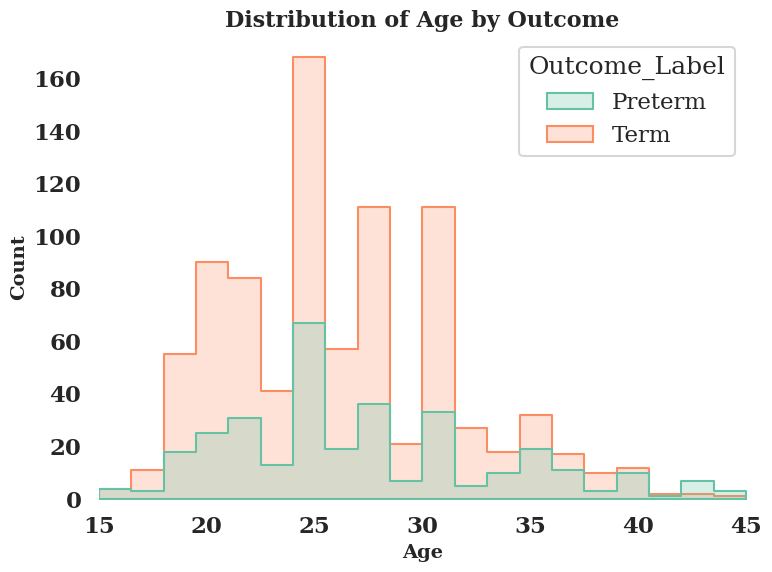

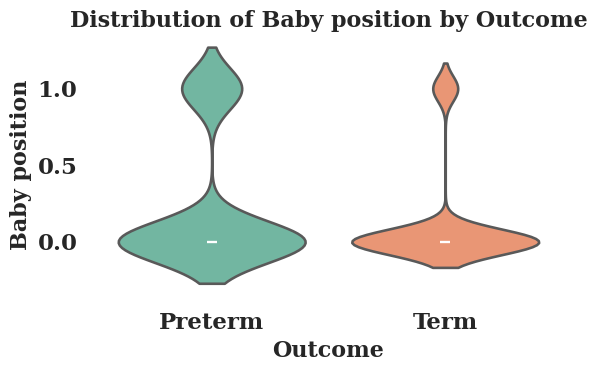

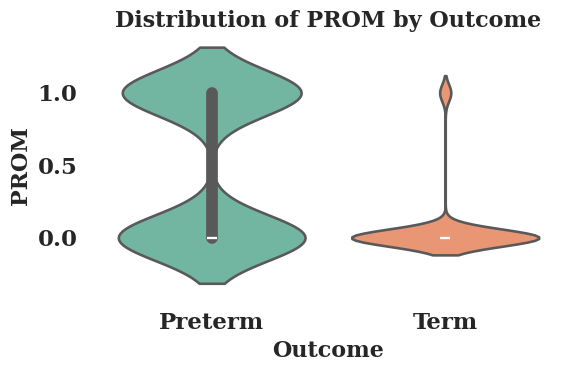

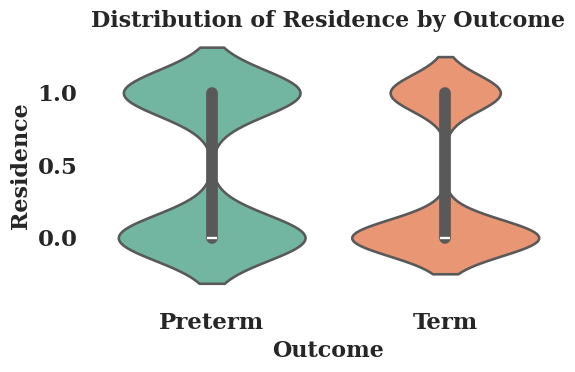

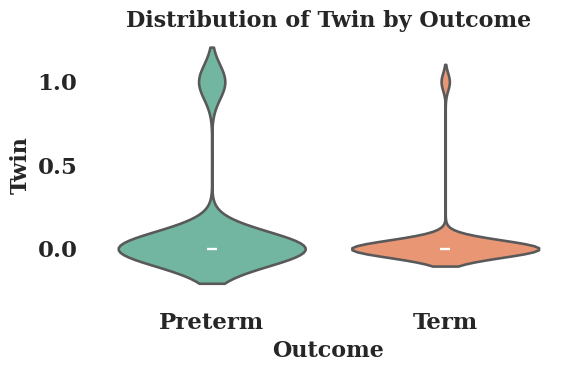

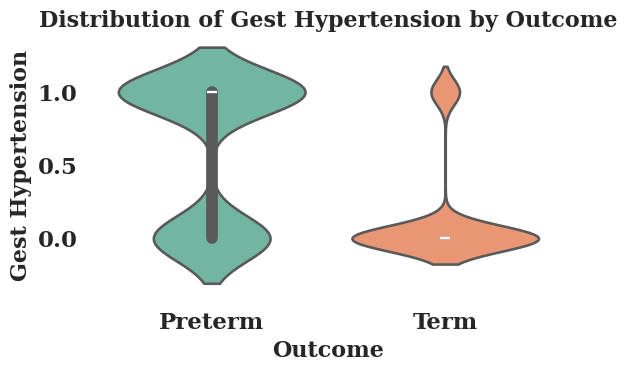

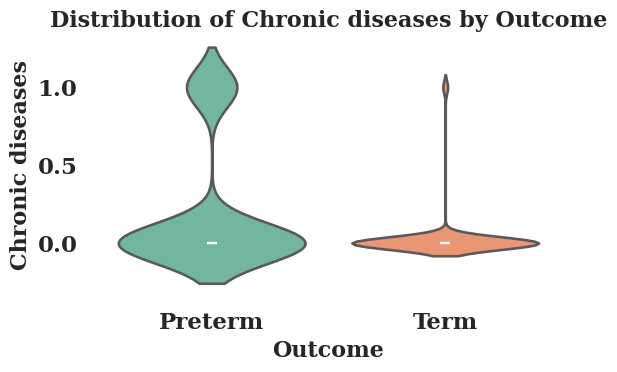

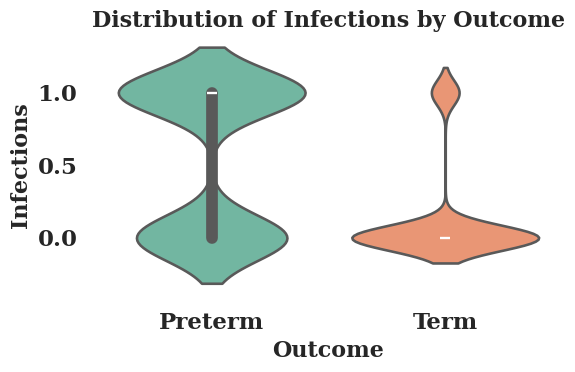

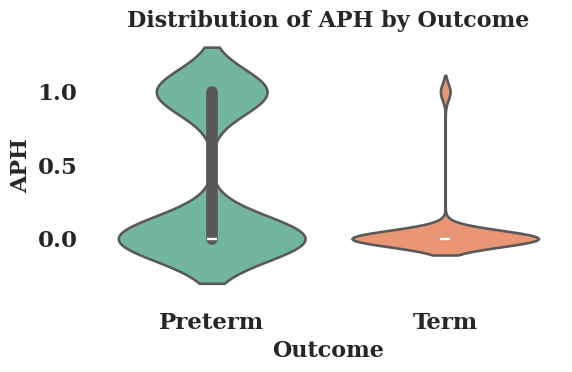

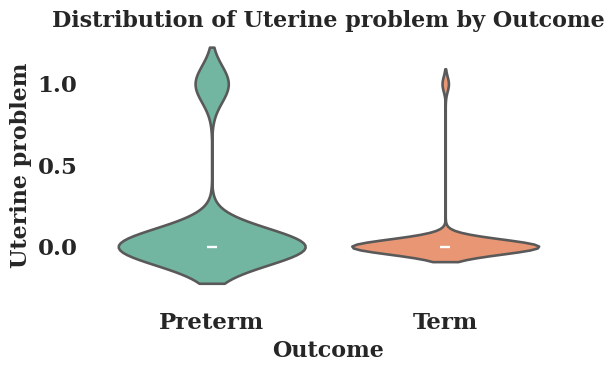

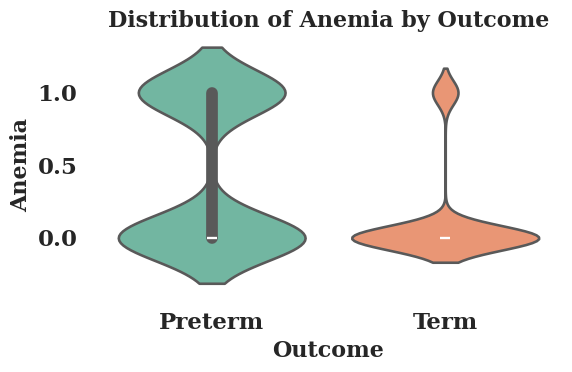

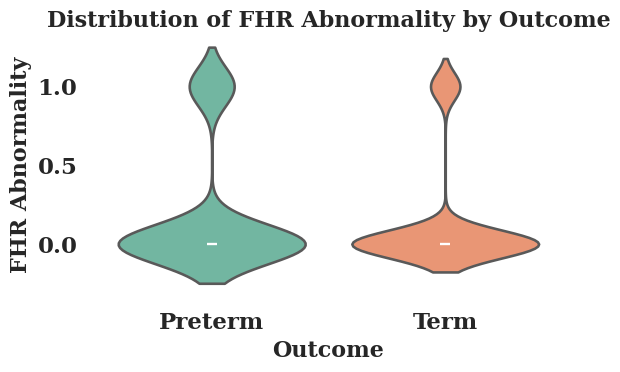

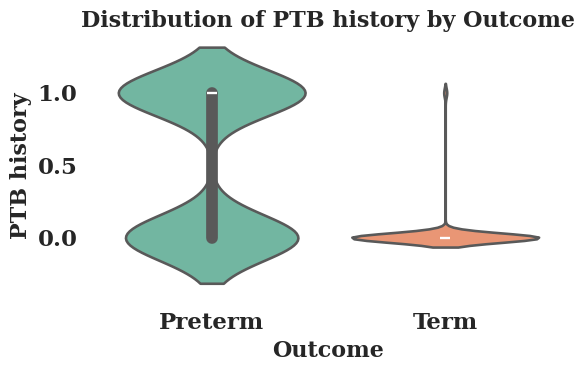

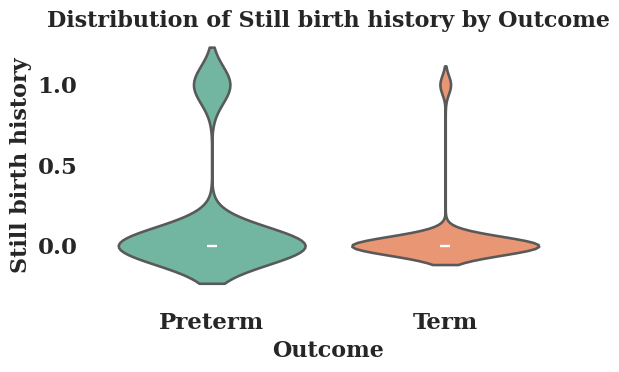

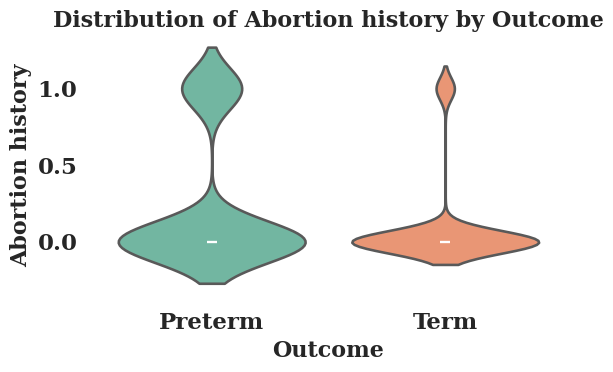

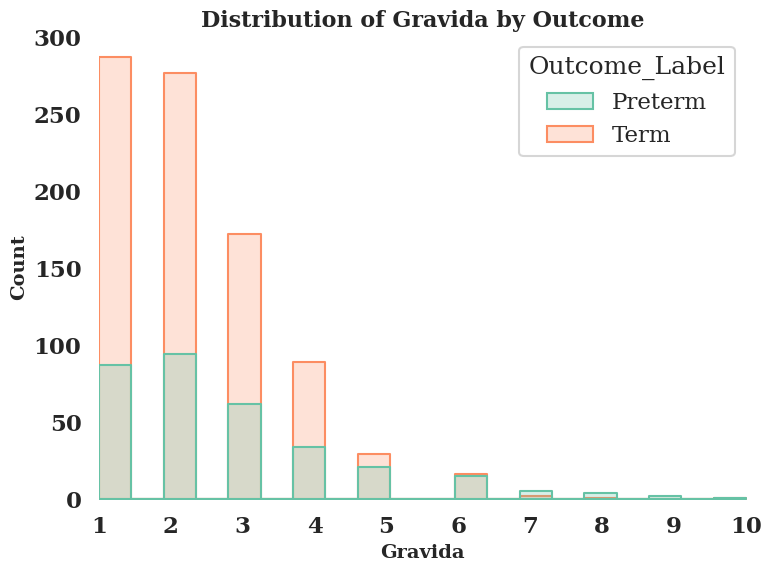

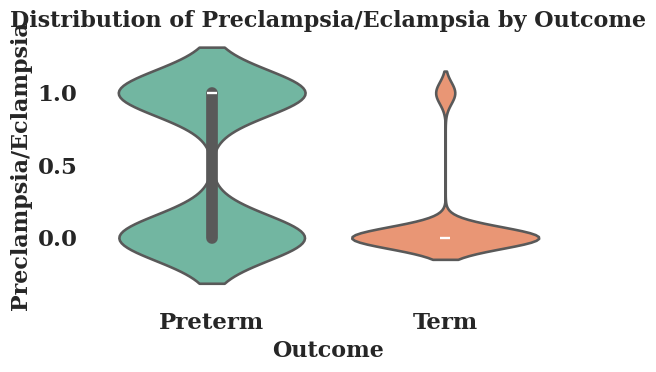

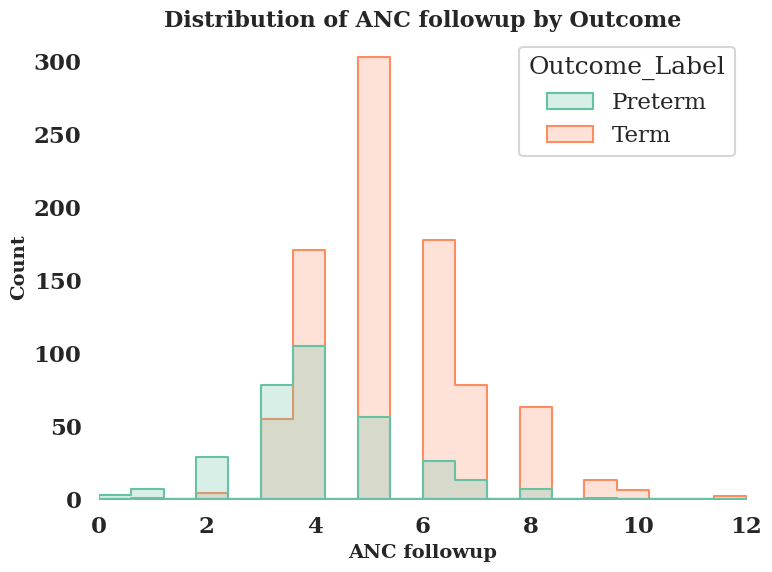

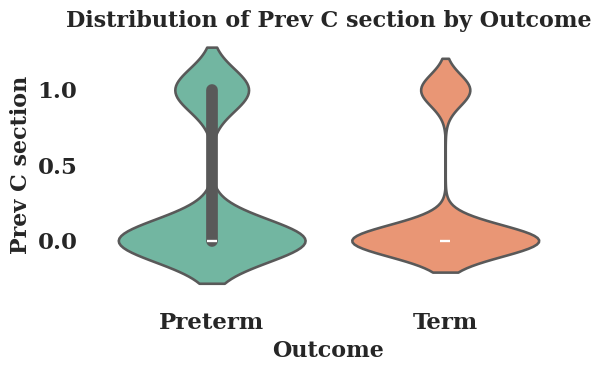

✅ All JHC_data figures saved in: JHC_feature_vs_outcome_figures


In [ ]:
# Use JHC_data
data = JHC_data.copy()
output_dir = "JHC_feature_vs_outcome_figures"
os.makedirs(output_dir, exist_ok=True)

numerical_cols = data.select_dtypes(include=np.number).columns.tolist()
if "Outcome" in numerical_cols:
    numerical_cols.remove("Outcome")

data_plot = data.copy()
data_plot["Outcome_Label"] = data_plot["Outcome"].map({0: "Term", 1: "Preterm"})

for col in numerical_cols:
    unique_vals = data_plot[col].dropna().unique()
    max_val = data_plot[col].max()

    if np.allclose(unique_vals, unique_vals.astype(int)) and max_val <= 3:
        plt.figure(figsize=(6, 4))
        ax = sns.violinplot(
            x="Outcome_Label",
            y=col,
            data=data_plot,
            palette="Set2",
            inner="box"
        )
        plt.ylabel(col, fontsize=16, fontweight='bold')
        plt.title(f'Distribution of {col} by Outcome', fontsize=16, fontweight='bold')
        plt.xlabel("Outcome", fontsize=16, fontweight='bold')
        plt.xticks(fontweight='bold')
        plt.yticks(fontweight='bold')
        sns.despine(left=True, bottom=True)
        ax.grid(False)

        fname = os.path.join(output_dir, f"{clean_filename(col)}_violin_vs_outcome.tiff")
        plt.tight_layout()
        plt.savefig(fname, dpi=600, bbox_inches="tight")
        plt.show()
        plt.close()
    else:
        plt.figure(figsize=(8, 6))
        ax = sns.histplot(
            data=data_plot,
            x=col,
            hue="Outcome_Label",
            palette="Set2",
            element="step",
            stat="count",
            bins=20,
            common_norm=False
        )
        counts = data_plot.groupby(["Outcome", col]).size().reset_index(name="count")
        nonzero_vals = counts.loc[counts["count"] > 0, col].unique()
        if len(nonzero_vals) > 0:
            ax.set_xlim(min(nonzero_vals), max(nonzero_vals))

        plt.title(f'Distribution of {col} by Outcome', fontsize=16, fontweight='bold')
        plt.xlabel(col, fontsize=14, fontweight='bold')
        plt.ylabel('Count', fontsize=14, fontweight='bold')
        plt.xticks(fontweight='bold')
        plt.yticks(fontweight='bold')
        sns.despine(left=True, bottom=True)
        ax.grid(False)

        fname = os.path.join(output_dir, f"{clean_filename(col)}_hist_vs_outcome.tiff")
        plt.tight_layout()
        plt.savefig(fname, dpi=600, bbox_inches="tight")
        plt.show()
        plt.close()

print("✅ All JHC_data figures saved in:", output_dir)


####Bivariate

Correlation map

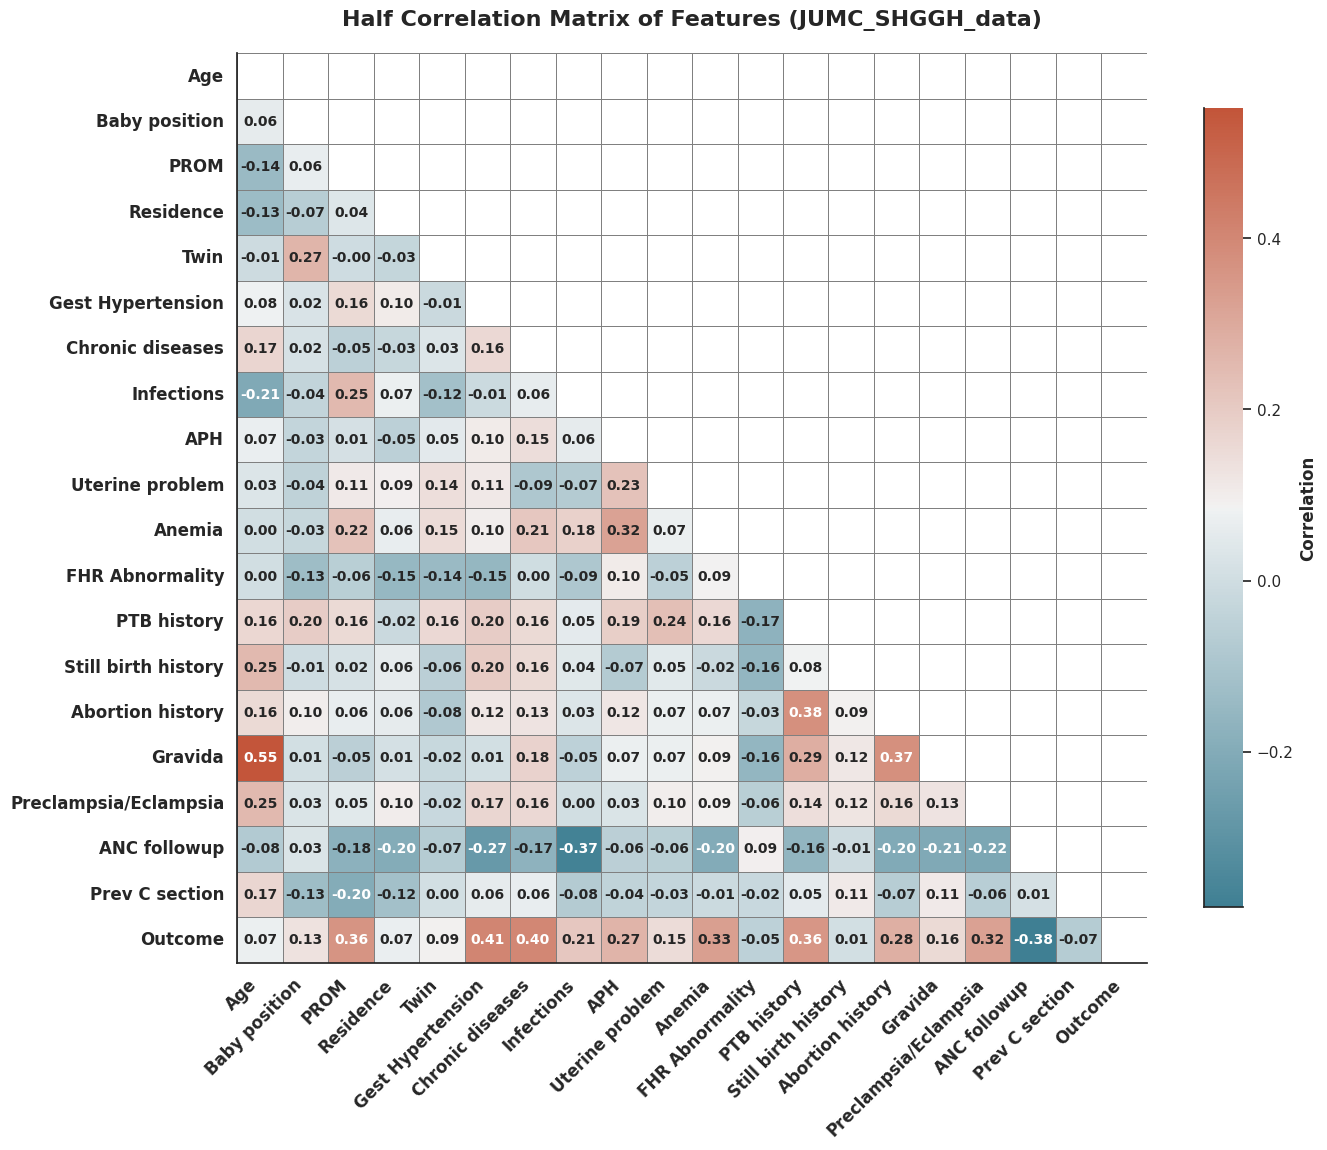

✅ Correlation heatmap saved: JUMC_SHGGH_figures/half_correlation_matrix.tiff


In [ ]:
# Use JUMC_SHGGH_data
data = JUMC_SHGGH_data.copy()

# --- Ensure output folder exists ---
output_dir = "JUMC_SHGGH_figures"
os.makedirs(output_dir, exist_ok=True)

# Ensure 'Outcome' is numeric
data['Outcome'] = data['Outcome'].replace({'Term': 0.0, 'Preterm': 1.0})
data['Outcome'] = pd.to_numeric(data['Outcome'], errors='coerce').astype(float)

# Handle potential NaNs in 'Outcome'
if data['Outcome'].isnull().any():
    print("NaN values found in 'Outcome' after coercing. Re-imputing...")
    if 'mice_imputer' in locals():
        data_imputed_array = mice_imputer.fit_transform(data)
        data = pd.DataFrame(data_imputed_array, columns=data.columns)
        print("Data after re-imputation:")
        print(data.isnull().sum())
    else:
        data['Outcome'] = data['Outcome'].fillna(data['Outcome'].mode()[0])

# Drop 'Birth Outcome' column if present
if 'Birth Outcome' in data.columns:
    data = data.drop('Birth Outcome', axis=1)

# --- Compute correlation matrix ---
corr_matrix = data.corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# --- Plotting ---
plt.figure(figsize=(14, 12))
sns.set(style="white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)

ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    square=True,
    linewidths=0.6,
    linecolor='gray',
    annot_kws={"size": 10, "weight": "bold"},
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12, fontweight='bold')

plt.title("Half Correlation Matrix of Features (JUMC_SHGGH_data)", fontsize=16, fontweight='bold', pad=20)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

save_path = os.path.join(output_dir, "half_correlation_matrix.tiff")
plt.savefig(save_path, dpi=600, bbox_inches="tight")
plt.show()
print(f"✅ Correlation heatmap saved: {save_path}")


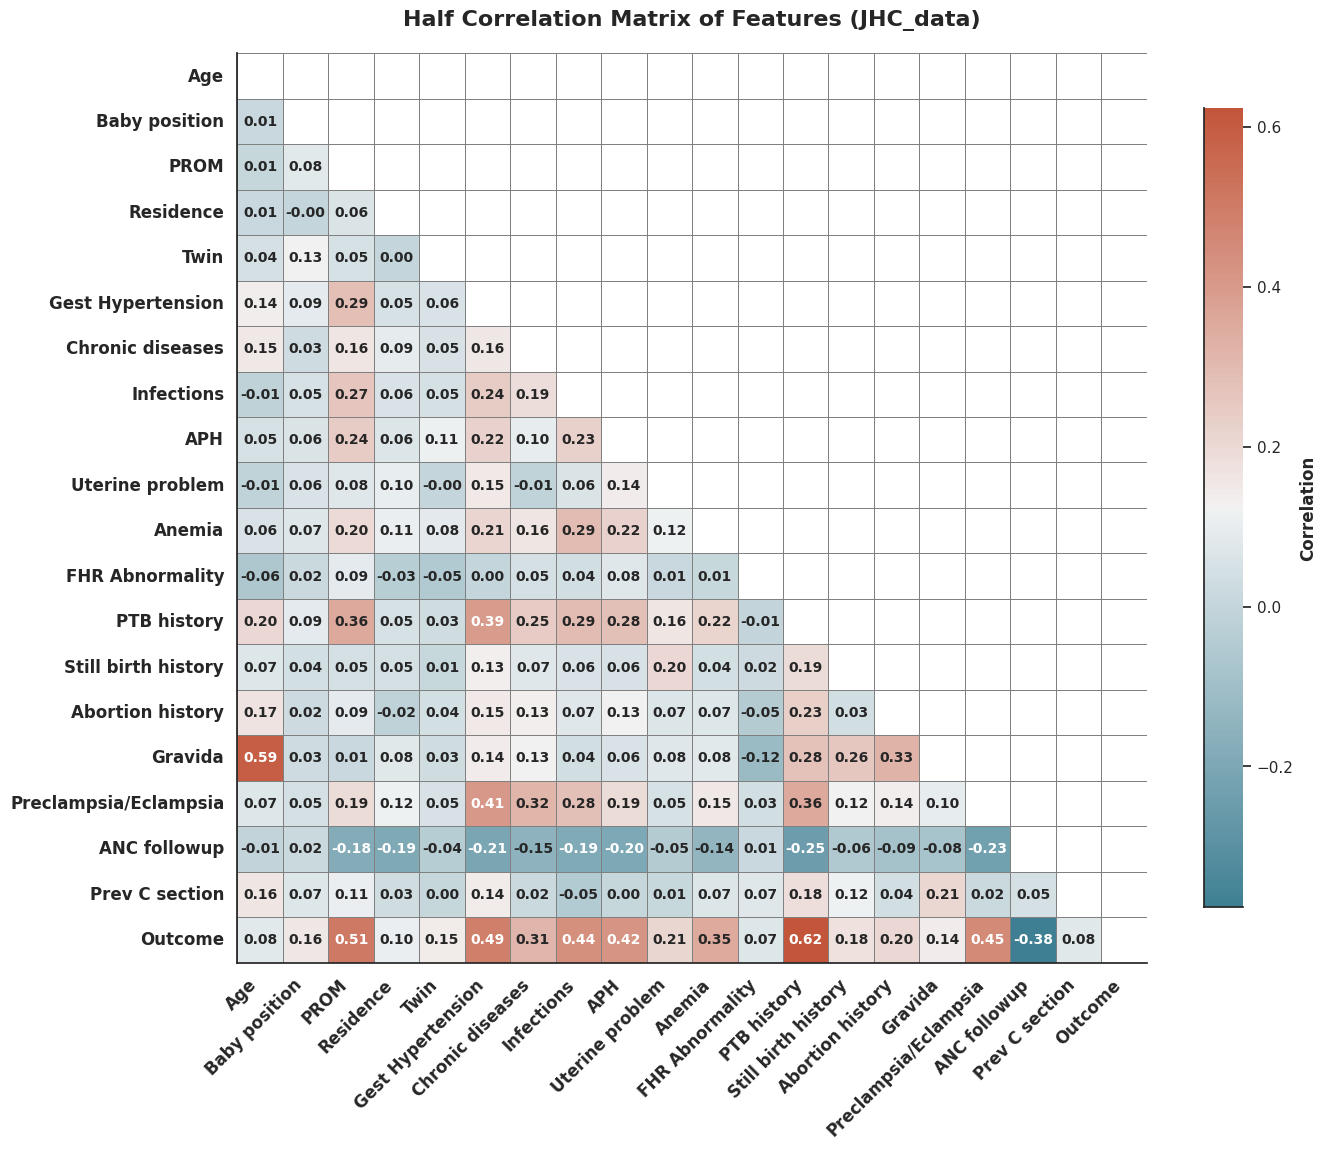

✅ Correlation heatmap saved: JHC_figures/half_correlation_matrix.tiff


In [ ]:
# Use JHC_data
data = JHC_data.copy()
output_dir = "JHC_figures"
os.makedirs(output_dir, exist_ok=True)

# Ensure 'Outcome' is numeric
data['Outcome'] = data['Outcome'].replace({'Term': 0.0, 'Preterm': 1.0})
data['Outcome'] = pd.to_numeric(data['Outcome'], errors='coerce').astype(float)

# Handle NaNs
if data['Outcome'].isnull().any():
    if 'mice_imputer' in locals():
        data_imputed_array = mice_imputer.fit_transform(data)
        data = pd.DataFrame(data_imputed_array, columns=data.columns)
    else:
        data['Outcome'] = data['Outcome'].fillna(data['Outcome'].mode()[0])

# Drop 'Birth Outcome' column if present
if 'Birth Outcome' in data.columns:
    data = data.drop('Birth Outcome', axis=1)

# Compute correlation matrix
corr_matrix = data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 12))
sns.set(style="white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)

ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    square=True,
    linewidths=0.6,
    linecolor='gray',
    annot_kws={"size": 10, "weight": "bold"},
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12, fontweight='bold')

plt.title("Half Correlation Matrix of Features (JHC_data)", fontsize=16, fontweight='bold', pad=20)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

save_path = os.path.join(output_dir, "half_correlation_matrix.tiff")
plt.savefig(save_path, dpi=600, bbox_inches="tight")
plt.show()
print(f"✅ Correlation heatmap saved: {save_path}")


###Class Balancing

Class distribution graph

Class distribution for 'Outcome' in JUMC_SHGGH_data:
Outcome
0    80
1    77
Name: count, dtype: int64


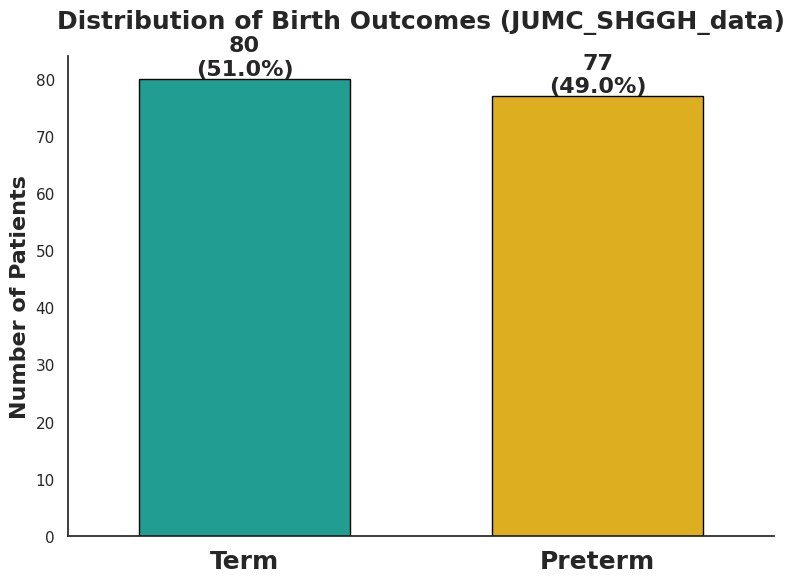

✅ Lancet-style distribution plot saved: JUMC_SHGGH_figures/Outcome_distribution_lancet_style.tiff


In [ ]:
# Use JUMC_SHGGH_data
data = JUMC_SHGGH_data.copy()

# --- Ensure output folder exists ---
output_dir = "JUMC_SHGGH_figures"
os.makedirs(output_dir, exist_ok=True)

# --- Specify target column ---
target_column = 'Outcome'

if target_column in data.columns:
    # --- Compute class distribution ---
    class_distribution = data[target_column].value_counts().sort_index()
    total = class_distribution.sum()
    print(f"Class distribution for '{target_column}' in JUMC_SHGGH_data:")
    print(class_distribution)

    # --- Professional style ---
    sns.set_theme(style="white")
    plt.figure(figsize=(8, 6))

    # Colors: Term = teal, Preterm = amber
    palette = {0: "#0db2a2", 1: "#febd01"}

    # Barplot
    ax = sns.barplot(
        x=class_distribution.index,
        y=class_distribution.values,
        palette=[palette[val] for val in class_distribution.index],
        edgecolor='black',
        width=0.6
    )

    # Annotate counts + percentages
    for p, val in zip(ax.patches, class_distribution.values):
        height = p.get_height()
        percent = (val / total) * 100
        ax.annotate(
            f'{val:,}\n({percent:.1f}%)',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom',
            fontsize=16, fontweight='bold'
        )

    # Title and labels
    ax.set_title("Distribution of Birth Outcomes (JUMC_SHGGH_data)", fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel("", fontsize=0)
    ax.set_ylabel("Number of Patients", fontsize=16, fontweight='bold')

    # Replace tick labels with clinical terms
    ax.set_xticks(range(len(class_distribution.index)))
    ax.set_xticklabels(["Term", "Preterm"], fontsize=18, fontweight='bold')

    sns.despine(left=False, bottom=False)
    ax.grid(False)

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"{target_column}_distribution_lancet_style.tiff")
    plt.savefig(save_path, dpi=600, bbox_inches="tight", transparent=True)
    plt.show()

    print(f"✅ Lancet-style distribution plot saved: {save_path}")

else:
    print(f"Target column '{target_column}' not found in JUMC_SHGGH_data.")


Class distribution for 'Outcome' in JHC_data:
Outcome
0    874
1    325
Name: count, dtype: int64


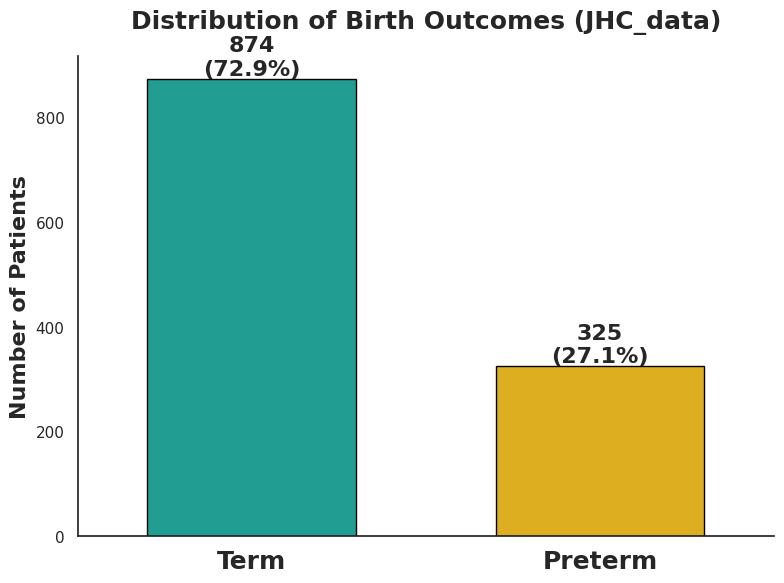

✅ Lancet-style distribution plot saved: JHC_figures/Outcome_distribution_lancet_style.tiff


In [ ]:
# Use JHC_data
data = JHC_data.copy()

# --- Ensure output folder exists ---
output_dir = "JHC_figures"
os.makedirs(output_dir, exist_ok=True)

# --- Specify target column ---
target_column = 'Outcome'

if target_column in data.columns:
    class_distribution = data[target_column].value_counts().sort_index()
    total = class_distribution.sum()
    print(f"Class distribution for '{target_column}' in JHC_data:")
    print(class_distribution)

    sns.set_theme(style="white")
    plt.figure(figsize=(8, 6))
    palette = {0: "#0db2a2", 1: "#febd01"}

    ax = sns.barplot(
        x=class_distribution.index,
        y=class_distribution.values,
        palette=[palette[val] for val in class_distribution.index],
        edgecolor='black',
        width=0.6
    )

    for p, val in zip(ax.patches, class_distribution.values):
        height = p.get_height()
        percent = (val / total) * 100
        ax.annotate(
            f'{val:,}\n({percent:.1f}%)',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom',
            fontsize=16, fontweight='bold'
        )

    ax.set_title("Distribution of Birth Outcomes (JHC_data)", fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel("", fontsize=0)
    ax.set_ylabel("Number of Patients", fontsize=16, fontweight='bold')
    ax.set_xticks(range(len(class_distribution.index)))
    ax.set_xticklabels(["Term", "Preterm"], fontsize=18, fontweight='bold')

    sns.despine(left=False, bottom=False)
    ax.grid(False)

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"{target_column}_distribution_lancet_style.tiff")
    plt.savefig(save_path, dpi=600, bbox_inches="tight", transparent=True)
    plt.show()

    print(f"✅ Lancet-style distribution plot saved: {save_path}")

else:
    print(f"Target column '{target_column}' not found in JHC_data.")


In [ ]:
# Features and target
X_train = JHC_data.drop(columns=['Outcome'])
y_train = JHC_data['Outcome']

X_test = JUMC_SHGGH_data.drop(columns=['Outcome'])
y_test = JUMC_SHGGH_data['Outcome']


Before SMOTEENN: Counter({np.int64(0): 874, np.int64(1): 325})
After SMOTEENN: Counter({np.int64(1): 628, np.int64(0): 614})


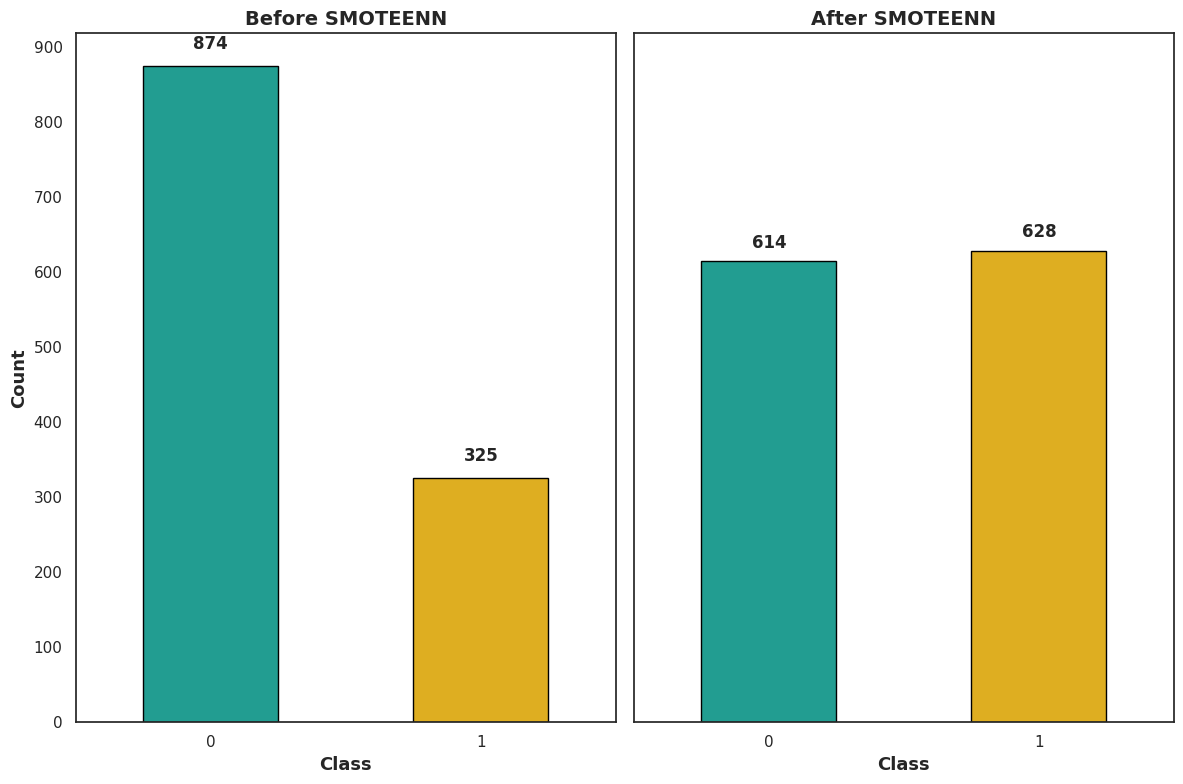

In [ ]:
# Simple SMOTEENN example with before/after plot


# --------- Safety / shape handling ----------
# Flatten image-like data (3D/4D) to 2D for SMOTEENN
if hasattr(X_train, "ndim") and X_train.ndim > 2:
    X_flat = X_train.reshape((X_train.shape[0], -1))
else:
    try:
        X_flat = X_train.values
    except Exception:
        X_flat = np.asarray(X_train)

y = np.asarray(y_train).ravel()

# --------- Print class distribution before ----------
before_counts = Counter(y)
print("Before SMOTEENN:", before_counts)

# --------- Apply SMOTEENN ----------
smoteenn = SMOTEENN(random_state=42)
X_res, y_res = smoteenn.fit_resample(X_flat, y)

# --------- Print class distribution after ----------
after_counts = Counter(y_res)
print("After SMOTEENN:", after_counts)

# ---------- Plot before vs after ----------
sns.set_style("white")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
})

fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

# Custom colors for each class
color_map = {"0": "#0db2a2", "1": "#febd01"}

# Helper function to plot counts
def plot_counts(ax, counts, title):
    classes = sorted(list(counts.keys()))
    values = [counts[c] for c in classes]
    labels = [str(c) for c in classes]

    sns.barplot(
        x=labels,
        y=values,
        ax=ax,
        palette=[color_map[l] for l in labels],
        edgecolor="black",
        linewidth=1,
        width=0.5   # <-- wider bars
    )

    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Annotate counts above bars
    for i, v in enumerate(values):
        ax.text(
            i,
            v + max(values) * 0.02 + 0.5,
            f"{v}",
            ha="center",
            va="bottom",
            fontweight="bold"
        )

# Draw plots
plot_counts(axes[0], before_counts, "Before SMOTEENN")
plot_counts(axes[1], after_counts, "After SMOTEENN")

plt.tight_layout()
plt.show()

# Optional: replace training set with balanced data
X_train, y_train = X_res, y_res


###Data Transformation

In [ ]:
# Initialize the PowerTransformer with the 'yeo-johnson' method
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_train = pt.fit_transform(X_train)
X_test = pt.transform(X_test)

###Data Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

###Data splitting

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Convert back to DataFrame/Series for iloc indexing
X_train_df = pd.DataFrame(X_train)
y_train_series = pd.Series(y_train)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_df, y_train_series), 1):
    X_fold_train, X_fold_val = X_train_df.iloc[train_idx], X_train_df.iloc[val_idx]
    y_fold_train, y_fold_val = y_train_series.iloc[train_idx], y_train_series.iloc[val_idx]

    print(f"Fold {fold}: Train size = {len(train_idx)}, Validation size = {len(val_idx)}")

Fold 1: Train size = 1117, Validation size = 125
Fold 2: Train size = 1117, Validation size = 125
Fold 3: Train size = 1118, Validation size = 124
Fold 4: Train size = 1118, Validation size = 124
Fold 5: Train size = 1118, Validation size = 124
Fold 6: Train size = 1118, Validation size = 124
Fold 7: Train size = 1118, Validation size = 124
Fold 8: Train size = 1118, Validation size = 124
Fold 9: Train size = 1118, Validation size = 124
Fold 10: Train size = 1118, Validation size = 124


##MODEL DEVELOPMENT

###Model Training and Evaluation

ML models

In [ ]:
from huggingface_hub import login

# Please create your own HF_token for TabPFN in hugging face, otherwise It won't run
login()

In [ ]:
# ------------------------------
# Ensure X_train and X_test are DataFrames
# ------------------------------
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train) # Convert y_train to a Series
X_test   = pd.DataFrame(X_test)
y_test = pd.Series(y_test) # Convert y_test to a Series for consistency

# Align columns between train and test
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Clean column names (keep alphanumeric, _, .)
X_train.columns = ["".join(c if c.isalnum() or c in ['_', '.'] else '_' for c in str(col)) for col in X_train.columns]
X_test.columns  = ["".join(c if c.isalnum() or c in ['_', '.'] else '_' for c in str(col)) for col in X_test.columns]

# ------------------------------
# Device for TabPFN
# ------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🖥️ Using device: {device}")

# ------------------------------
# Define models
# ------------------------------
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "TabPFN": TabPFNClassifier(device=device, ignore_pretraining_limits=True),
}

# ------------------------------
# Training & Evaluation
# ------------------------------
results = {}
max_train_samples = 1024  # TabPFN limit

for name, model in models.items():
    print(f"\n🔧 Training {name}...")

    # Handle TabPFN sample limit
    if name == "TabPFN" and X_train.shape[0] > max_train_samples:
        X_train_sub = X_train.iloc[:max_train_samples]
        y_train_sub = y_train.iloc[:max_train_samples]
        model.fit(X_train_sub, y_train_sub)
    else:
        model.fit(X_train, y_train)

    # Predictions & probabilities
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]  # probability for positive class
    else:  # TabPFN
        y_proba = model.predict(X_test, return_type='probabilities')[:,1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_text = classification_report(y_test, y_pred)

    # Binary classification labels
    labels = [label for label in report_dict.keys() if label not in ['accuracy','macro avg','weighted avg']]
    if len(labels) == 2:
        negative_label, positive_label = sorted(labels)
        try:
            sensitivity = report_dict[positive_label]['recall']
            specificity = report_dict[negative_label]['recall']
        except KeyError:
            sensitivity = specificity = float('nan')
    else:
        sensitivity = specificity = float('nan')

    # Save results
    results[name] = {
        "accuracy": acc,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc": auc_score,
        "report": report_text,
        "y_proba": y_proba
    }

    # ------------------------------
    # ROC curve
    # ------------------------------
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, color='#0db2a2', lw=3, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0,1], [0,1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title(f'ROC Curve — {name}', fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f'ROC_{name}.tiff', dpi=600)
    plt.close()

# ------------------------------
# Display Summary
# ------------------------------
print("\n" + "="*40)
print("📊 MULTI-MODEL PERFORMANCE SUMMARY")
print("="*40)
for name, res in results.items():
    print(f"\n🔹 {name}")
    print(f"✅ Accuracy   : {res['accuracy']:.4f}")
    print(f"📈 Sensitivity: {res['sensitivity']:.4f}")
    print(f"📉 Specificity: {res['specificity']:.4f}")
    print(f"🎯 AUC       : {res['auc']:.4f}")
    print("📋 Classification Report:")
    print(res['report'])

🖥️ Using device: cpu

🔧 Training Random Forest...

🔧 Training XGBoost...

🔧 Training CatBoost...

🔧 Training LightGBM...
[LightGBM] [Info] Number of positive: 628, number of negative: 614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 1242, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505636 -> initscore=0.022545
[LightGBM] [Info] Start training from score 0.022545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

🔧 Training TabPFN...


tabpfn-v2.5-classifier-v2.5_default.ckpt:   0%|          | 0.00/42.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]


📊 MULTI-MODEL PERFORMANCE SUMMARY

🔹 Random Forest
✅ Accuracy   : 0.8153
📈 Sensitivity: 0.7922
📉 Specificity: 0.8375
🎯 AUC       : 0.8712
📋 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        80
           1       0.82      0.79      0.81        77

    accuracy                           0.82       157
   macro avg       0.82      0.81      0.82       157
weighted avg       0.82      0.82      0.82       157


🔹 XGBoost
✅ Accuracy   : 0.8025
📈 Sensitivity: 0.7662
📉 Specificity: 0.8375
🎯 AUC       : 0.8688
📋 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81        80
           1       0.82      0.77      0.79        77

    accuracy                           0.80       157
   macro avg       0.80      0.80      0.80       157
weighted avg       0.80      0.80      0.80       157


🔹 CatBoost
✅ Accuracy   : 0.7962
📈 Sensitivity: 0.7662
📉 S

TabNet

In [ ]:
print("\n📌 TabNet Binary Classifier\n")
# TabNet requires numpy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# --- Start of suggested fix: Handle NaN values ---
# Import SimpleImputer if not already imported
from sklearn.impute import SimpleImputer

# Initialize a SimpleImputer to fill NaNs with the mean
imputer = SimpleImputer(strategy='mean')

# Fit on training data and transform both train and test
X_train_np = imputer.fit_transform(X_train_np)
X_test_np = imputer.transform(X_test_np)
# --- End of suggested fix ---

print(f"✅ Training samples: {X_train.shape[0]}")
print(f"✅ Testing samples : {X_test.shape[0]}")

# DEVICE SETUP
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🖥️ Using device: {device}")

#MODEL DEFINITION
model = TabNetClassifier(
    device_name=device,
    verbose=0,
    optimizer_params=dict(lr=2e-2)
)

# 6. TRAINING
print("\n🔧 Training TabNet model...")
model.fit(
    X_train_np, y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    patience=10,
    max_epochs=50
)
print("✅ Training complete.")

# PREDICTION
print("\n🔍 Evaluating model...")
y_pred = model.predict(X_test_np)

# Get predicted probabilities for AUC
y_proba = model.predict_proba(X_test_np)[:, 1]  # probability for positive class

# METRICS CALCULATION
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_text = classification_report(y_test, y_pred)

# Sensitivity and Specificity
labels = [label for label in report_dict.keys() if label not in ['accuracy', 'macro avg', 'weighted avg']]
if len(labels) == 2:
    negative_label, positive_label = sorted(labels)
    try:
        sensitivity = report_dict[positive_label]['recall']    # True Positive Rate
        specificity = report_dict[negative_label]['recall']    # True Negative Rate
    except KeyError:
        sensitivity = specificity = float('nan')
else:
    print(f"⚠️ Unexpected number of labels: {labels}")
    sensitivity = specificity = float('nan')

# AUC
auc_score = roc_auc_score(y_test, y_proba)

#OUTPUT RESULTS
print("\n" + "="*40)
print("📊 MODEL PERFORMANCE")
print("="*40)
print(f"✅ Accuracy   : {accuracy:.4f}")
print(f"📈 Sensitivity: {sensitivity:.4f}")
print(f"📉 Specificity: {specificity:.4f}")
print(f"🎯 AUC        : {auc_score:.4f}")
print("\n📋 Full Classification Report:\n")
print(report_text)


📌 TabNet Binary Classifier

✅ Training samples: 1242
✅ Testing samples : 157
🖥️ Using device: cpu

🔧 Training TabNet model...

Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_auc = 0.85032
✅ Training complete.

🔍 Evaluating model...

📊 MODEL PERFORMANCE
✅ Accuracy   : 0.7707
📈 Sensitivity: 0.7403
📉 Specificity: 0.8000
🎯 AUC        : 0.8503

📋 Full Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.80      0.78        80
           1       0.78      0.74      0.76        77

    accuracy                           0.77       157
   macro avg       0.77      0.77      0.77       157
weighted avg       0.77      0.77      0.77       157



TabTransformer

In [ ]:
# ------------------ Data Preparation ------------------
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🖥️ Using device: {device}")

# ------------------ TabTransformer Definition ------------------
class TabTransformer(nn.Module):
    def __init__(self, num_features, num_classes, dim=32, depth=2, heads=4, attn_dropout=0.1, ff_dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(num_features, dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim, nhead=heads, dim_feedforward=dim*4, dropout=attn_dropout, batch_first=True
            ),
            num_layers=depth
        )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x.float())
        x = self.transformer(x.unsqueeze(1)).squeeze(1)
        return self.mlp_head(x)

# ------------------ Model Initialization ------------------
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))
tab_transformer = TabTransformer(num_features, num_classes).to(device)

optimizer = torch.optim.Adam(tab_transformer.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ------------------ Training Loop ------------------
epochs = 50
for epoch in range(epochs):
    tab_transformer.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = tab_transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")

# ------------------ Evaluation ------------------
tab_transformer.eval()
all_preds, all_probs = [], []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = tab_transformer(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_true = y_test_tensor.numpy()
y_pred = np.array(all_preds)
y_proba = np.array(all_probs)

# ------------------ Metrics Computation (same logic as Code 1) ------------------
if len(np.unique(y_true)) == 2:
    # --- Binary classification ---
    y_proba_pos = y_proba[:, 1]

    # Classification report
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    report_text = classification_report(y_true, y_pred)

    # Identify labels
    labels = [label for label in report_dict.keys() if label not in ['accuracy', 'macro avg', 'weighted avg']]
    negative_label, positive_label = sorted(labels)

    # Sensitivity (recall of positive class)
    sensitivity = report_dict[positive_label]['recall']

    # Specificity (recall of negative class)
    specificity = report_dict[negative_label]['recall']

    acc = accuracy_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_proba_pos)

else:
    # --- Multi-class case ---
    sensitivity = float('nan')
    specificity = float('nan')
    acc = accuracy_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
    report_text = classification_report(y_true, y_pred)

# ------------------ Results Summary ------------------
metrics = {
    "Accuracy": acc,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
    "AUC": auc_score,
    "Classification Report": report_text
}

print("\n" + "="*40)
print("📊 TABTRANSFORMER PERFORMANCE SUMMARY")
print("="*40)
for k, v in metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}:\n{v}")


🖥️ Using device: cpu
Epoch 1/50 - Loss: 0.1264
Epoch 2/50 - Loss: 0.1303
Epoch 3/50 - Loss: 0.0141
Epoch 4/50 - Loss: 0.0571
Epoch 5/50 - Loss: 0.0918
Epoch 6/50 - Loss: 0.0700
Epoch 7/50 - Loss: 0.0921
Epoch 8/50 - Loss: 0.0219
Epoch 9/50 - Loss: 0.0371
Epoch 10/50 - Loss: 0.1507
Epoch 11/50 - Loss: 0.0376
Epoch 12/50 - Loss: 0.0598
Epoch 13/50 - Loss: 0.0092
Epoch 14/50 - Loss: 0.0386
Epoch 15/50 - Loss: 0.0049
Epoch 16/50 - Loss: 0.0102
Epoch 17/50 - Loss: 0.0195
Epoch 18/50 - Loss: 0.0761
Epoch 19/50 - Loss: 0.2061
Epoch 20/50 - Loss: 0.0162
Epoch 21/50 - Loss: 0.0201
Epoch 22/50 - Loss: 0.0026
Epoch 23/50 - Loss: 0.0105
Epoch 24/50 - Loss: 0.0190
Epoch 25/50 - Loss: 0.1102
Epoch 26/50 - Loss: 0.0363
Epoch 27/50 - Loss: 0.0098
Epoch 28/50 - Loss: 0.0045
Epoch 29/50 - Loss: 0.0208
Epoch 30/50 - Loss: 0.0191
Epoch 31/50 - Loss: 0.0016
Epoch 32/50 - Loss: 0.0771
Epoch 33/50 - Loss: 0.0046
Epoch 34/50 - Loss: 0.0282
Epoch 35/50 - Loss: 0.1693
Epoch 36/50 - Loss: 0.0275
Epoch 37/50 - Lo

TabM

In [ ]:
# ------------------ Data Preparation ------------------
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🖥️ Using device: {device}")

# ------------------ Define TabM (MLP-based Model) ------------------
class TabM(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.layers(x.float())

# ------------------ Model Initialization ------------------
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))
tab_m_model = TabM(num_features, num_classes).to(device)

optimizer = torch.optim.Adam(tab_m_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ------------------ Training Loop ------------------
epochs = 50
for epoch in range(epochs):
    tab_m_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = tab_m_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

# ------------------ Evaluation ------------------
tab_m_model.eval()
all_preds, all_probs = [], []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = tab_m_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_true = y_test_tensor.numpy()
y_pred = np.array(all_preds)
y_proba = np.array(all_probs)

# ------------------ Metrics Computation (same logic as Code 1) ------------------
if len(np.unique(y_true)) == 2:
    # --- Binary classification ---
    y_proba_pos = y_proba[:, 1]

    # Classification report
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    report_text = classification_report(y_true, y_pred)

    # Identify labels
    labels = [label for label in report_dict.keys() if label not in ['accuracy', 'macro avg', 'weighted avg']]
    negative_label, positive_label = sorted(labels)

    # Sensitivity (recall of positive class)
    sensitivity = report_dict[positive_label]['recall']

    # Specificity (recall of negative class)
    specificity = report_dict[negative_label]['recall']

    acc = accuracy_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_proba_pos)

else:
    # --- Multi-class case ---
    sensitivity = float('nan')
    specificity = float('nan')
    acc = accuracy_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
    report_text = classification_report(y_true, y_pred)

# ------------------ Results Summary ------------------
metrics = {
    "Accuracy": acc,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
    "AUC": auc_score,
    "Classification Report": report_text
}

print("\n" + "="*40)
print("📊 TABM (MLP) PERFORMANCE SUMMARY")
print("="*40)
for k, v in metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}:\n{v}")


🖥️ Using device: cpu
Epoch 1/50 - Loss: 0.3418
Epoch 2/50 - Loss: 0.1536
Epoch 3/50 - Loss: 0.1353
Epoch 4/50 - Loss: 0.1141
Epoch 5/50 - Loss: 0.1107
Epoch 6/50 - Loss: 0.0996
Epoch 7/50 - Loss: 0.0934
Epoch 8/50 - Loss: 0.0820
Epoch 9/50 - Loss: 0.0695
Epoch 10/50 - Loss: 0.0689
Epoch 11/50 - Loss: 0.0695
Epoch 12/50 - Loss: 0.0638
Epoch 13/50 - Loss: 0.0526
Epoch 14/50 - Loss: 0.0431
Epoch 15/50 - Loss: 0.0552
Epoch 16/50 - Loss: 0.0424
Epoch 17/50 - Loss: 0.0428
Epoch 18/50 - Loss: 0.0459
Epoch 19/50 - Loss: 0.0357
Epoch 20/50 - Loss: 0.0402
Epoch 21/50 - Loss: 0.0332
Epoch 22/50 - Loss: 0.0322
Epoch 23/50 - Loss: 0.0321
Epoch 24/50 - Loss: 0.0273
Epoch 25/50 - Loss: 0.0371
Epoch 26/50 - Loss: 0.0330
Epoch 27/50 - Loss: 0.0260
Epoch 28/50 - Loss: 0.0202
Epoch 29/50 - Loss: 0.0264
Epoch 30/50 - Loss: 0.0276
Epoch 31/50 - Loss: 0.0227
Epoch 32/50 - Loss: 0.0259
Epoch 33/50 - Loss: 0.0232
Epoch 34/50 - Loss: 0.0208
Epoch 35/50 - Loss: 0.0182
Epoch 36/50 - Loss: 0.0202
Epoch 37/50 - Lo

###Model Performance Visualization

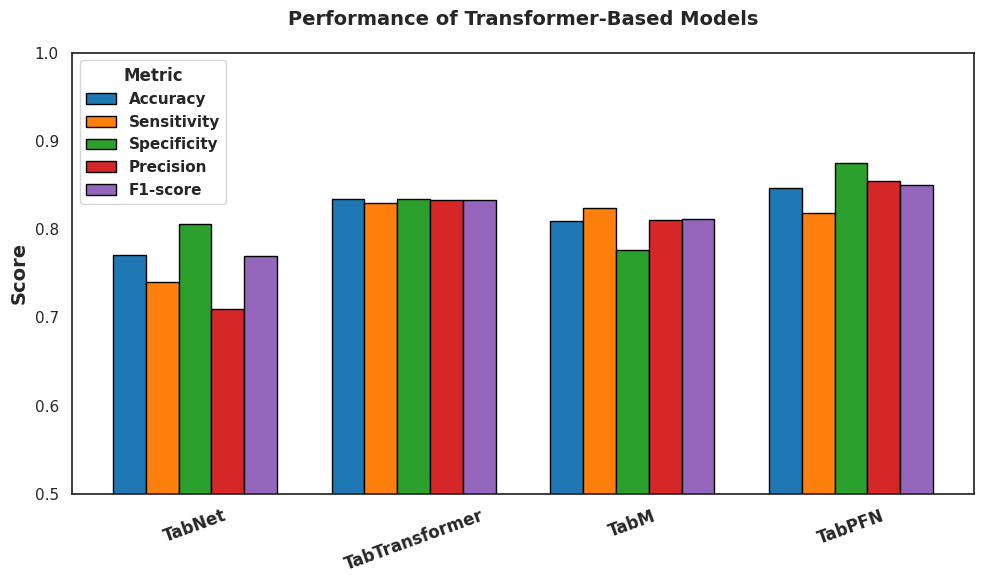

In [ ]:
# --- Model performance data ---
data = {
    'Model': ['TabNet', 'TabTransformer', 'TabM', 'TabPFN'],
    'Accuracy': [0.7707, 0.8341, 0.8089, 0.8471],
    'Sensitivity': [0.7403, 0.8301, 0.8242, 0.8182],
    'Specificity': [0.806, 0.834, 0.776,0.8751],
    'Precision': [0.71, 0.833, 0.81, 0.855],
    'F1-score': [0.770, 0.833, 0.811,0.85]
}

df = pd.DataFrame(data)

# --- Figure setup ---
plt.figure(figsize=(10,6))
index = np.arange(len(df['Model']))
width = 0.15  # width of each bar

# --- Clean publication-friendly colors ---
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-score']

# --- Plot grouped bars ---
for i, metric in enumerate(metrics):
    plt.bar(
        index + i*width - width*2,  # center the group
        df[metric],
        width=width,
        color=colors[i],
        edgecolor='black',
        label=metric
    )

# --- Axis labels and title ---
plt.xticks(index, df['Model'], fontsize=12, fontweight='bold', rotation=20)
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.ylim(0.5, 1.0)
plt.title('Performance of Transformer-Based Models', fontsize=14, fontweight='bold', pad=20)

# --- Legend ---
leg = plt.legend(title='Metric', fontsize=11, title_fontsize=12)
plt.setp(leg.get_texts(), fontweight='bold')  # bold legend labels
plt.setp(leg.get_title(), fontweight='bold')  # bold legend title

# --- Remove grid ---
plt.grid(False)

plt.tight_layout()
plt.savefig('tabular_models_grouped_bar_clean.tiff', dpi=600, bbox_inches='tight')
plt.show()


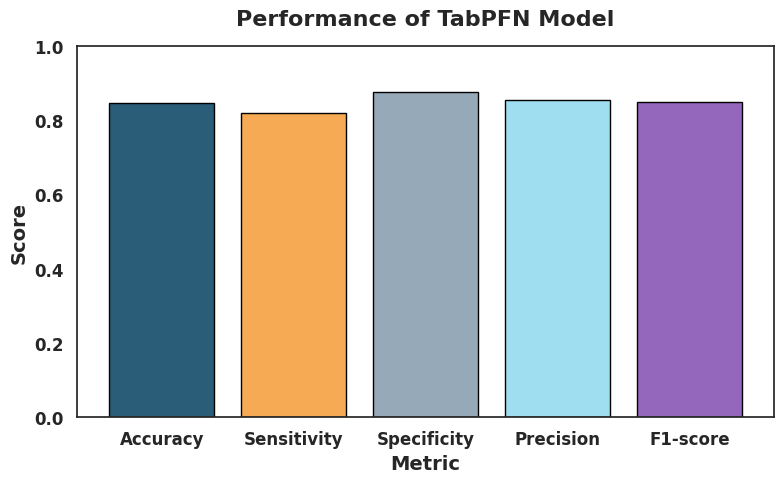

In [ ]:
# --- TabPFN performance data ---
data = {
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-score'],
    'Score': [0.8471, 0.8182, 0.8751, 0.855, 0.85]
}

df = pd.DataFrame(data)

# --- Figure setup ---
plt.figure(figsize=(8,5))

# --- Colors for metrics ---
colors = ['#2a5d78', '#f6aa54', '#96a9b8', '#9fdef0', '#9467bd']

# --- Plot bars ---
plt.bar(df['Metric'], df['Score'], color=colors, edgecolor='black')

# --- Axis labels and title ---
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.xlabel('Metric', fontsize=14, fontweight='bold')
plt.ylim(0.0, 1)
plt.title('Performance of TabPFN Model', fontsize=16, fontweight='bold', pad=15)

# --- Bold x-ticks ---
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# --- Clean layout ---
plt.tight_layout()

# --- Save figure ---
plt.savefig('tabpfn_single_bar_plot.tiff', dpi=600, bbox_inches='tight')
plt.show()


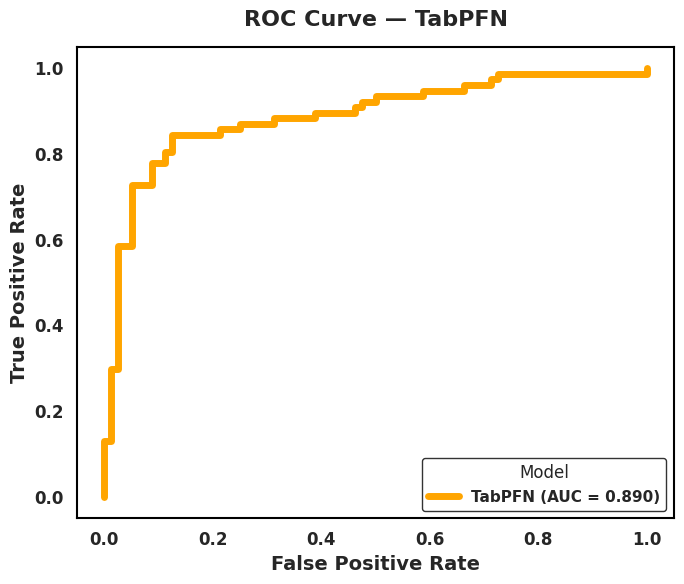

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- Extract TabPFN predictions and probabilities ---
tabpfn_results = results['TabPFN']
y_proba = tabpfn_results['y_proba']

# Compute ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# --- Plot ROC ---
plt.figure(figsize=(7,6))

# Bold/thick ROC line (RED)
plt.plot(
    fpr,
    tpr,
    color='orange',        # 🔴 ROC curve color changed to RED
    lw=5,               # thick line for bold effect
    label=f'TabPFN (AUC = {auc_score:.3f})'
)

# Axes labels
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')

# Title
plt.title('ROC Curve — TabPFN', fontsize=16, fontweight='bold', pad=15)

# Ticks
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Legend with bold text
plt.legend(
    loc='lower right',
    fontsize=12,
    title='Model',
    title_fontsize=12,
    frameon=True,
    edgecolor='black',
    prop={'weight':'bold'}
)

# Remove grid
plt.grid(False)

# Draw box/frame around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('black')

plt.tight_layout()
plt.savefig('ROC_TabPFN_final_publication.tiff', dpi=600, bbox_inches='tight')
plt.show()


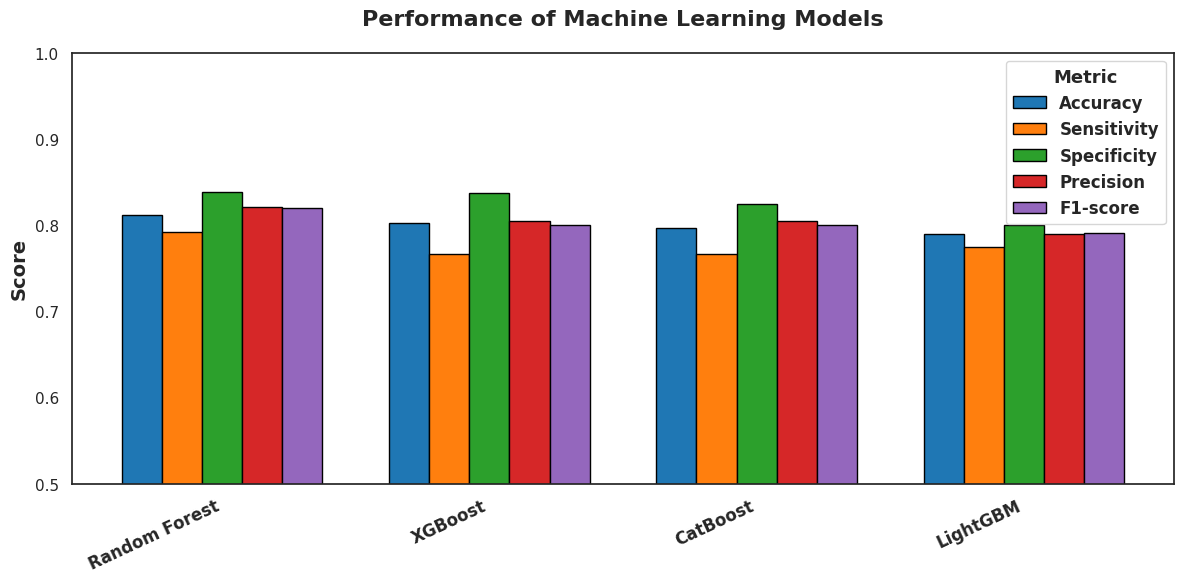

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Model performance data ---
data = {
    'Model': ['Random Forest', 'XGBoost', 'CatBoost', 'LightGBM'],
    'Accuracy': [0.8118, 0.8025, 0.7961, 0.7898],
    'Sensitivity': [0.7925, 0.7662, 0.7662, 0.7748],
    'Specificity': [0.8381, 0.8376, 0.8250, 0.8004],
    'Precision': [0.821, 0.805, 0.805, 0.790],
    'F1-score': [0.82, 0.80, 0.80, 0.791]
}

df = pd.DataFrame(data)

# --- Figure setup ---
plt.figure(figsize=(12,6))
index = np.arange(len(df['Model']))
width = 0.15  # width of each bar

# --- Colors and metrics ---
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-score']

# --- Plot grouped bars ---
for i, metric in enumerate(metrics):
    plt.bar(
        index + i*width - width*2,  # center the group
        df[metric],
        width=width,
        color=colors[i],
        edgecolor='black',
        label=metric
    )

# --- Axis labels and title ---
plt.xticks(index, df['Model'], rotation=25, ha='right', fontsize=12, fontweight='bold')  # bold x-ticks
plt.ylabel('Score', fontsize=14, fontweight='bold')                                      # bold y-label
plt.ylim(0.5, 1)
plt.title('Performance of Machine Learning Models', fontsize=16, fontweight='bold', pad=20)  # bold title

# --- Legend ---
leg = plt.legend(title='Metric', fontsize=12, title_fontsize=13)
plt.setp(leg.get_texts(), fontweight='bold')  # bold legend labels
plt.setp(leg.get_title(), fontweight='bold')  # bold legend title

# --- Remove grid ---
plt.grid(False)

plt.tight_layout()
plt.savefig('ml_models_grouped_bar_clean.tiff', dpi=600, bbox_inches='tight')
plt.show()


ROC Curve

Using device: cpu
Training TabM...
TabM Epoch 1/10 - Loss: 0.3373
TabM Epoch 2/10 - Loss: 0.1632
TabM Epoch 3/10 - Loss: 0.1389
TabM Epoch 4/10 - Loss: 0.1205
TabM Epoch 5/10 - Loss: 0.1092
TabM Epoch 6/10 - Loss: 0.0978
TabM Epoch 7/10 - Loss: 0.0859
TabM Epoch 8/10 - Loss: 0.0856
TabM Epoch 9/10 - Loss: 0.0769
TabM Epoch 10/10 - Loss: 0.0705
Training TabTransformer...
TabTransformer Epoch 1/10 - Loss: 0.2451
TabTransformer Epoch 2/10 - Loss: 0.1580
TabTransformer Epoch 3/10 - Loss: 0.1403
TabTransformer Epoch 4/10 - Loss: 0.1288
TabTransformer Epoch 5/10 - Loss: 0.1085
TabTransformer Epoch 6/10 - Loss: 0.1203
TabTransformer Epoch 7/10 - Loss: 0.1046
TabTransformer Epoch 8/10 - Loss: 0.0860
TabTransformer Epoch 9/10 - Loss: 0.0840
TabTransformer Epoch 10/10 - Loss: 0.0697
Training TabNet (pytorch_tabnet)...
epoch 0  | loss: 0.83731 | valid_auc: 0.68799 |  0:00:02s
epoch 1  | loss: 0.65775 | valid_auc: 0.74334 |  0:00:03s
epoch 2  | loss: 0.56585 | valid_auc: 0.80674 |  0:00:06s
epoch 

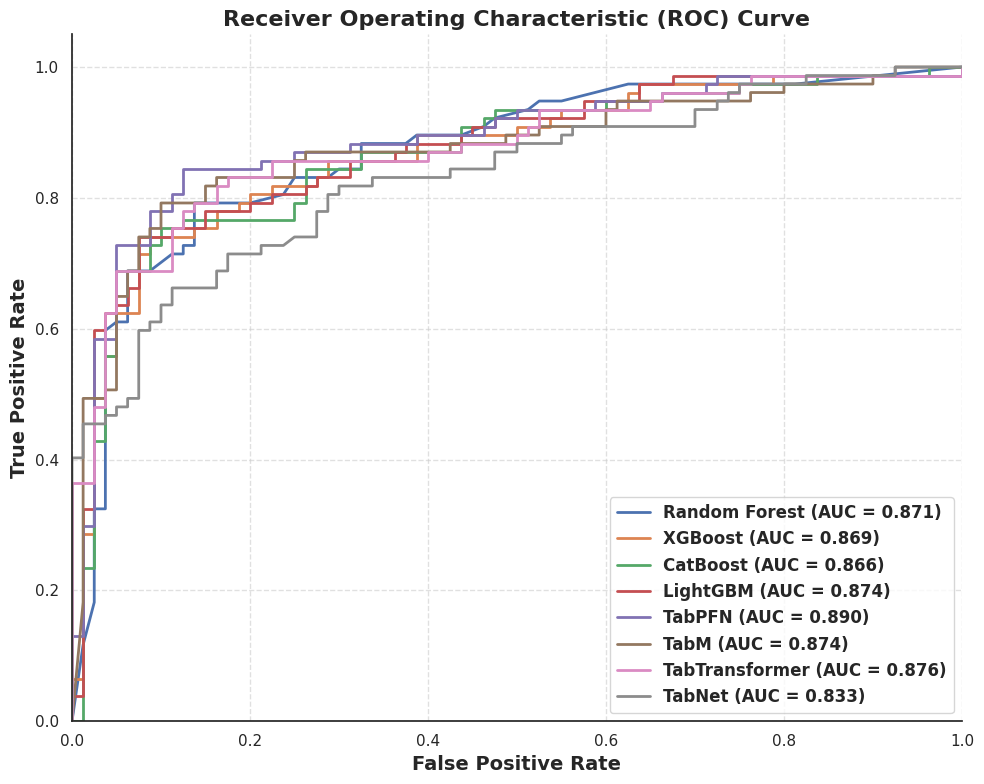

✅ ROC curve plot generated and saved as 'roc_final_curve_all_models_bold.tiff'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


try:
    from google.colab import files
    _HAS_COLAB = True
except Exception:
    _HAS_COLAB = False

# --- Optional: install pytorch-tabnet if missing (only in environments with internet)
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    _HAS_TABNET_LIB = True
except Exception:
    _HAS_TABNET_LIB = False
    try:
        # Try to install (works in Colab/normal pip-enabled environments)
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorch-tabnet"], stdout=subprocess.DEVNULL)
        from pytorch_tabnet.tab_model import TabNetClassifier
        _HAS_TABNET_LIB = True
    except Exception:
        _HAS_TABNET_LIB = False
        print("⚠ pytorch-tabnet not available. TabNet training will be skipped. "
              "To enable TabNet, install 'pytorch-tabnet' (pip install pytorch-tabnet).")


# ------------------ Step 0: Prepare tensors & loaders ------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Convert (assumes X_train, X_test, y_train, y_test exist)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_features = X_train.shape[1]
classes = np.unique(y_train)
num_classes = len(classes)

# Helper to get y_true for metrics (numpy)
y_true = y_test_tensor.cpu().numpy()

# ------------------ Step 1: TabM (MLP-based) Definition ------------------
class TabM(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.layers(x.float())

# Initialize TabM
tab_m_model = TabM(num_features, num_classes).to(device)
optimizer_tabm = torch.optim.Adam(tab_m_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training TabM
epochs = 10
print("Training TabM...")
for epoch in range(epochs):
    tab_m_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_tabm.zero_grad()
        outputs = tab_m_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_tabm.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"TabM Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

# Evaluation TabM
tab_m_model.eval()
all_preds, all_probs = [], []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = tab_m_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_pred_tabm = np.array(all_preds)
y_proba_tabm = np.array(all_probs)  # shape: (n_samples, num_classes)

# ------------------ Step 2: TabTransformer Definition ------------------
class TabTransformer(nn.Module):
    def __init__(self, num_features, num_classes, dim=64, depth=2, heads=4, attn_dropout=0.1, ff_dropout=0.1):
        super().__init__()
        # A simple embedding via linear layer then transformer encoder
        self.embedding = nn.Linear(num_features, dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, nhead=heads, dim_feedforward=dim*4,
            dropout=attn_dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
    def forward(self, x):
        # embed and run through transformer (treat features as a single token dimension)
        x = self.embedding(x.float())
        # using unsqueeze to create sequence dim of length 1 so transformer works
        x = self.transformer(x.unsqueeze(1)).squeeze(1)
        return self.mlp_head(x)

tab_transformer = TabTransformer(num_features, num_classes, dim=64, depth=2, heads=4).to(device)
optimizer_tt = torch.optim.Adam(tab_transformer.parameters(), lr=1e-3)

# Training TabTransformer
print("Training TabTransformer...")
for epoch in range(epochs):
    tab_transformer.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_tt.zero_grad()
        outputs = tab_transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_tt.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"TabTransformer Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

# Evaluation TabTransformer
tab_transformer.eval()
all_preds, all_probs = [], []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = tab_transformer(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_pred_tt = np.array(all_preds)
y_proba_tt = np.array(all_probs)

# ------------------ Step 3: TabNet (via pytorch_tabnet) ------------------
y_proba_tabnet = None
y_pred_tabnet = None
auc_tabnet = None

if _HAS_TABNET_LIB:
    print("Training TabNet (pytorch_tabnet)...")
    # pytorch_tabnet expects numpy arrays
    X_train_np = X_train.values.astype(np.float32)
    y_train_np = y_train.values
    X_test_np = X_test.values.astype(np.float32)
    y_test_np = y_test.values

    # If binary classification, TabNetClassifier defaults to out_dim=1; ensure categorical_handling is not used here.
    tabnet_clf = TabNetClassifier(
        n_d=32, n_a=32, n_steps=3, gamma=1.3,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-3),
        mask_type='sparsemax'
    )

    # Fit (small number of epochs; increase for better performance)
    tabnet_clf.fit(
        X_train_np, y_train_np,
        eval_set=[(X_test_np, y_test_np)],
        eval_name=['valid'],
        eval_metric=['auc' if num_classes==2 else 'logloss'],
        max_epochs=epochs,
        patience=50,
        batch_size=batch_size,
        virtual_batch_size=16,
        num_workers=0,
        drop_last=False
    )

    # Predict probabilities
    proba = tabnet_clf.predict_proba(X_test_np)  # shape (n_samples, num_classes) for multiclass, or (n_samples,2) for binary
    y_proba_tabnet = np.array(proba)
    y_pred_tabnet = tabnet_clf.predict(X_test_np)

    try:
        if num_classes == 2:
            auc_tabnet = roc_auc_score(y_test_np, y_proba_tabnet[:, 1])
        else:
            auc_tabnet = roc_auc_score(y_test_np, y_proba_tabnet, multi_class="ovr", average="weighted")
    except Exception as e:
        print(f"⚠ Error computing TabNet AUC: {e}")
else:
    print("Skipping TabNet: 'pytorch_tabnet' not installed.")

# ------------------ Step 4: Collect all results ------------------
all_model_results = {}

# 4a: Classical models from 'results' dict (if provided in workspace)
if 'results' in locals():
    for name, res in results.items():
        try:
            if 'y_proba' in res and 'auc' in res:
                y_proba = res['y_proba']
                # Ensure 1D probs for binary
                all_model_results[name] = {'y_proba': np.array(y_proba), 'auc': float(res['auc'])}
            else:
                print(f"⚠ Missing 'y_proba' or 'auc' for {name}")
        except Exception as e:
            print(f"⚠ Error processing classical result {name}: {e}")

# 4b: TabM
try:
    if num_classes == 2:
        auc_tabm = roc_auc_score(y_true, y_proba_tabm[:, 1])
    else:
        auc_tabm = roc_auc_score(y_true, y_proba_tabm, multi_class="ovr", average="weighted")
    all_model_results['TabM'] = {'y_proba': y_proba_tabm, 'auc': auc_tabm}
except Exception as e:
    print(f"⚠ Error computing TabM AUC: {e}")

# 4c: TabTransformer
try:
    if num_classes == 2:
        auc_tt = roc_auc_score(y_true, y_proba_tt[:, 1])
    else:
        auc_tt = roc_auc_score(y_true, y_proba_tt, multi_class="ovr", average="weighted")
    all_model_results['TabTransformer'] = {'y_proba': y_proba_tt, 'auc': auc_tt}
except Exception as e:
    print(f"⚠ Error computing TabTransformer AUC: {e}")

# 4d: TabNet (if available)
if y_proba_tabnet is not None:
    try:
        all_model_results['TabNet'] = {'y_proba': y_proba_tabnet, 'auc': float(auc_tabnet) if auc_tabnet is not None else None}
    except Exception as e:
        print(f"⚠ Error adding TabNet results: {e}")

# ------------------ Step 5: Plot ROC curves ------------------
if not all_model_results:
    print("❌ No model results found for plotting.")
else:
    plt.figure(figsize=(10,8))
    sns.set_style("white")

    for name, res in all_model_results.items():
        y_proba_plot = res['y_proba']
        # If shape is (n_samples, n_classes), get positive class probs for binary
        if y_proba_plot.ndim == 2 and y_proba_plot.shape[1] == 2:
            y_proba_plot = y_proba_plot[:, 1]
        try:
            fpr, tpr, _ = roc_curve(y_true, y_proba_plot)
            auc_val = res.get('auc', None)
            label_auc = f"{name} (AUC = {auc_val:.3f})" if auc_val is not None else name
            plt.plot(fpr, tpr, lw=2, label=label_auc)
        except Exception as e:
            # For multiclass, try to compute an OVR ROC for each class and average — but keep it simple here.
            print(f"⚠ Could not plot ROC for {name}: {e}")
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')

    legend = plt.legend(loc='lower right', fontsize=12)
    for text in legend.get_texts():
        text.set_fontweight('bold')

    plt.grid(True, linestyle='--', alpha=0.6)
    sns.despine()
    plt.tight_layout()

    out_name = 'roc_final_curve_all_models_bold.tiff'
    plt.savefig(out_name, dpi=600, bbox_inches='tight', format='tiff')
    plt.show()
    print(f"✅ ROC curve plot generated and saved as '{out_name}'")

    # Optional download in Colab
    if _HAS_COLAB:
        files.download(out_name)


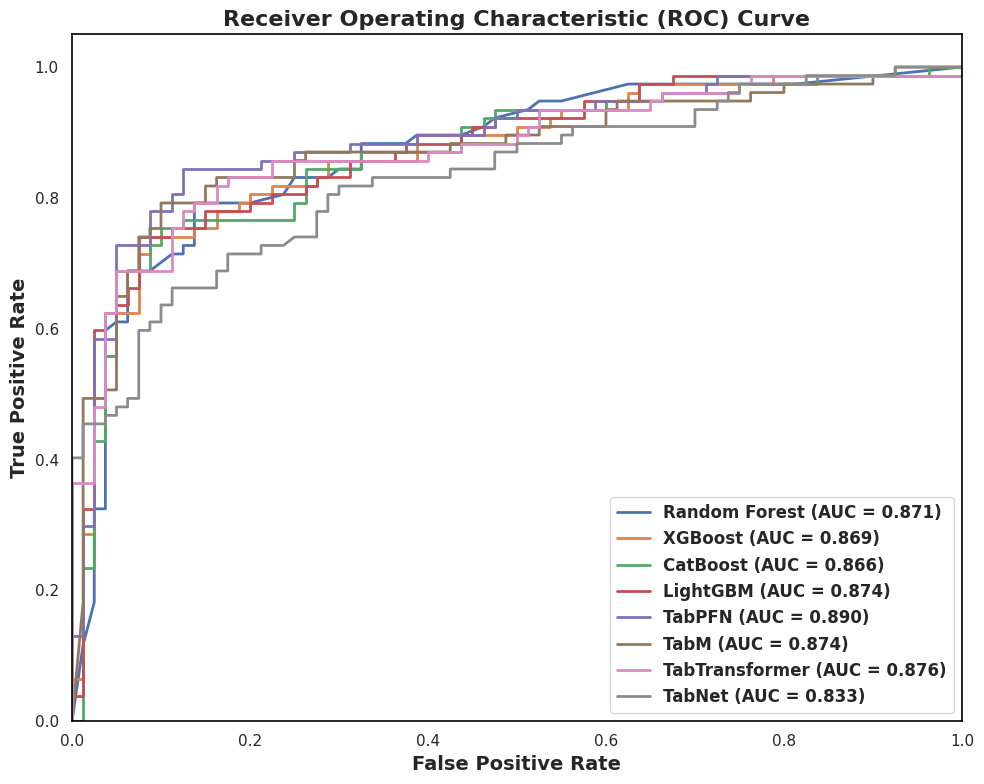

In [ ]:
# ------------------------------
# Assumes these already exist:
# y_true, all_model_results
# ------------------------------

plt.figure(figsize=(10, 8))
sns.set_style("white")

for name, res in all_model_results.items():
    y_proba_plot = res['y_proba']
    if y_proba_plot.ndim == 2 and y_proba_plot.shape[1] == 2:
        y_proba_plot = y_proba_plot[:, 1]

    try:
        fpr, tpr, _ = roc_curve(y_true, y_proba_plot)
        auc_val = res.get('auc', None)
        label_auc = f"{name} (AUC = {auc_val:.3f})" if auc_val is not None else name
        plt.plot(fpr, tpr, lw=2, label=label_auc)
    except Exception as e:
        print(f"⚠ Could not plot ROC for {name}: {e}")

# Diagonal random guess line
#plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random Guess (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')

# Legend styling
legend = plt.legend(loc='lower right', fontsize=12)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Remove grid
plt.grid(False)

# Add visible box (all 4 spines)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color('black')

plt.tight_layout()
plt.savefig("roc_final_curve_all_models_boxed.tiff", dpi=600, bbox_inches='tight')
plt.show()


**Confusion matrix for the best performing model**

NameError: name 'Path' is not defined

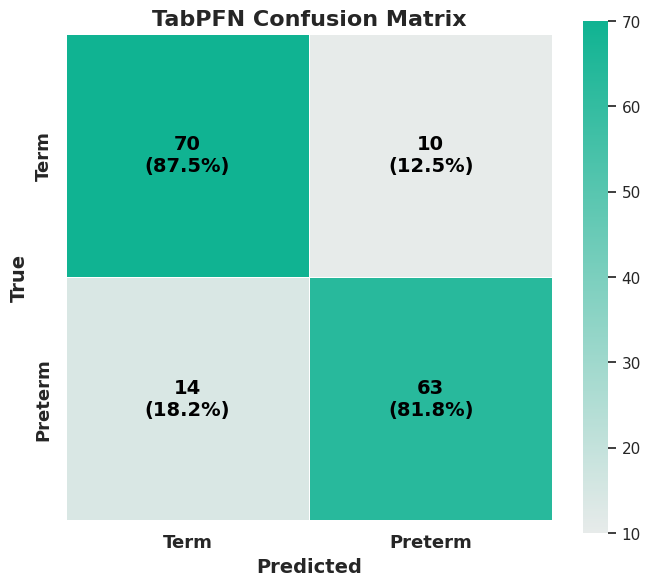

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

y_true = y_test.values  # ensure numpy array
y_pred = models['TabPFN'].predict(X_test)  # predictions

labels_for_cm = np.array([0,1])
tick_labels = ['Term', 'Preterm']

# confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels_for_cm)
cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cmn = np.nan_to_num(cmn)

# annotations
annot = np.empty_like(cm).astype(object)
for r in range(cm.shape[0]):
    for c in range(cm.shape[1]):
        annot[r, c] = f"{int(cm[r,c])}\n({cmn[r,c]*100:0.1f}%)"

# soft colormap
colors = ["#e7ebea", "#10b392"]
cmap_custom = LinearSegmentedColormap.from_list("soft_gradient", colors)

# plot
plt.figure(figsize=(7,6))
ax = sns.heatmap(
    cm,
    annot=annot,
    fmt='',
    cmap=cmap_custom,
    cbar=True,
    xticklabels=tick_labels,
    yticklabels=tick_labels,
    linewidths=0.5,
    linecolor='white',
    square=True,
    annot_kws={"size":14, "weight":"bold", "color":"black"}
)
ax.set_xlabel("Predicted", fontsize=14, fontweight='bold')
ax.set_ylabel("True", fontsize=14, fontweight='bold')
ax.set_title(f"TabPFN Confusion Matrix", fontsize=16, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13, fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=13, fontweight='bold')
plt.tight_layout()

out_dir = Path("confusion_matrix_plots")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "confusion_matrix_TabPFN.tiff"
plt.savefig(out_path, dpi=600, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {out_path}")
